<a href="https://colab.research.google.com/github/vn322/Cod_future/blob/main/%D0%A3%D0%BF%D1%80%D0%B0%D0%B6%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BF%D0%BE_%D0%BF%D0%BE%D0%B4%D0%B3%D0%BE%D1%82%D0%BE%D0%B2%D0%BA%D0%B5_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

# Ошибки в данных

Ошибки в данных могут встречаться по многим причинам. Они могут быть связаны с человеческим фактором, например, простой невнимательностью, или вызваны сбоями в работе записывающего какие-либо показатели оборудования.

В качестве примера мы будем использовать несложный датасет, в котором содержатся данные  об отдельных финансовых показателях сети магазинов , представленной в нескольких городах мира. В частности, нам доступна следующая информация:

month — за какой месяц сделана запись

profit — прибыль (profit) по сети

MoM — изменение выручки (revenue) сети по отношению к предыдущему месяцу

high — магазин с наибольшей маржинальностью (margin) продаж

In [2]:
# создадим датафрейм из словаря
financials = pd.DataFrame({'month' :   ['01/01/2022', '01/02/2022', '01/03/2022', '01/03/2022', '01/04/2022', '01/05/2022', '01/06/2022', '01/07/2022', '01/08/2022', '01/09/2022', '01/10/2022', '01/11/2022', '01/12/2022', '01/12/2022'],
                           'profit' :  ['1.20$', '1.30$', '1.25$', '1.25$', '1.27$', '1.13$', '1.23$', '1.20$', '1.31$', '1.24$', '1.18$', '1.17$', '1.23$', '1.23$'],
                           'MoM' :     [0.03, -0.02, 0.01, 0.02, -0.01, -0.015, 0.017, 0.035, 0.02, 0.01, 0.00, -0.01, 2.00, 2.00],
                           'high' :    ['Dubai', 'Paris', 'singapour', 'singapour', 'moscow', 'Paris', 'Madrid', 'moscow', 'london', 'london', 'Moscow', 'Rome', 'madrid', 'madrid']
                           })

financials

,month,profit,MoM,high
0,01/01/2022,1.20$,0.030,Dubai
1,01/02/2022,1.30$,-0.020,Paris
2,01/03/2022,1.25$,0.010,singapour
3,01/03/2022,1.25$,0.020,singapour
4,01/04/2022,1.27$,-0.010,moscow
5,01/05/2022,1.13$,-0.015,Paris
6,01/06/2022,1.23$,0.017,Madrid
7,01/07/2022,1.20$,0.035,moscow
8,01/08/2022,1.31$,0.020,london
9,01/09/2022,1.24$,0.010,london


Воспользуемся методом .info() для получения общей информации

In [3]:
# вначале получим общее представление о данных
financials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   14 non-null     object 
 1   profit  14 non-null     object 
 2   MoM     14 non-null     float64
 3   high    14 non-null     object 
dtypes: float64(1), object(3)
memory usage: 576.0+ bytes


## Дубликаты


### Поиск дубликатов
Заметим, что хотя данные представлены за 12 месяцев, в датафрейме тем не менее содержится 14 значений. Это заставляет задуматься о дубликатах (duplicates) или повторяющихся значениях. Воспользуемся методом .duplicated(). На выходе мы получим логический массив, в котором повторяющееся значение обозначено как True.

In [4]:
# keep = 'first' (параметр по умолчанию)
# помечает как дубликат (True) ВТОРОЕ повторяющееся значение
financials.duplicated(keep = 'first')

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13     True
dtype: bool

In [5]:
# keep = 'last' соответственно считает дубликатом ПЕРВОЕ повторяющееся значение
financials.duplicated(keep = 'last')

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12     True
13    False
dtype: bool

In [6]:
# результат метода .duplicated() можно использовать как фильтр
financials[financials.duplicated(keep = 'last')]

,month,profit,MoM,high
12,01/12/2022,1.23$,2.0,madrid


если смотреть по месяцам, у нас две дублирующихся записи, а не одна. В частности, повторяется запись не только за декабрь, но и за март. Проверим это с помощью параметра subset.

In [7]:
# если смотреть по месяцам, у нас два дубликата, а не один
# с помощью параметра subset мы ищем дубликаты по конкретным столбцам
financials.duplicated(subset = ['month'])

0     False
1     False
2     False
3      True
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13     True
dtype: bool

Создадим новый фильтр и выведем дубликаты по месяцам.

In [8]:
# и если смотреть по месяцм, дубликатов не один, а два
financials.duplicated(subset = ['month']).sum()

2

In [9]:
# создадим новый фильтр и выведем дубликаты по месяцам
financials[financials.duplicated(subset = ['month'], keep = 'last')]

,month,profit,MoM,high
2,01/03/2022,1.25$,0.01,singapour
12,01/12/2022,1.23$,2.00,madrid


In [10]:
# аналогично мы можем посмотреть на неповторяющиеся значения
( ~ financials.duplicated(subset = ['month'])).sum()

12

In [11]:
# этот логический массив можно также использовать как фильтр
financials[ ~ financials.duplicated(subset = ['month'], keep = 'last')]

,month,profit,MoM,high
0,01/01/2022,1.20$,0.030,Dubai
1,01/02/2022,1.30$,-0.020,Paris
3,01/03/2022,1.25$,0.020,singapour
4,01/04/2022,1.27$,-0.010,moscow
5,01/05/2022,1.13$,-0.015,Paris
6,01/06/2022,1.23$,0.017,Madrid
7,01/07/2022,1.20$,0.035,moscow
8,01/08/2022,1.31$,0.020,london
9,01/09/2022,1.24$,0.010,london
10,01/10/2022,1.18$,0.000,Moscow


 индекс остался прежним (из него просто выпали наблюдения 2 и 12). Мы исправим эту неточность при удалении дубликатов.

### Удаление дубликатов

Метод .drop_duplicates() удаляет дубликаты из датафрейма и, по сути, принимает те же параметры, что и метод .duplicated().

In [12]:
# метод .drop_duplicates() удаляет дубликаты и
# по сути принимает те же параметры, что и .duplicated()
financials.drop_duplicates(keep = 'last',
                           subset = ['month'],
                           ignore_index = True,
                           inplace = True)
financials

,month,profit,MoM,high
0,01/01/2022,1.20$,0.030,Dubai
1,01/02/2022,1.30$,-0.020,Paris
2,01/03/2022,1.25$,0.020,singapour
3,01/04/2022,1.27$,-0.010,moscow
4,01/05/2022,1.13$,-0.015,Paris
5,01/06/2022,1.23$,0.017,Madrid
6,01/07/2022,1.20$,0.035,moscow
7,01/08/2022,1.31$,0.020,london
8,01/09/2022,1.24$,0.010,london
9,01/10/2022,1.18$,0.000,Moscow


## Неверные значения

Распространенным типом ошибок в данных являются неверные значения.

Базовый подход к поиску неверных значений — проверить, что данные не противоречат своей природе. Например, цена товара не может быть отрицательной.

В нашем случае мы видим, что в столбце MoM все строки отражают доли процента, а последняя строка — проценты. Из-за этого сильно искажается, например, средний показатель изменения выручки за год.

Доли процента и проценты

In [13]:
# рассчитаем среднемесячное изменение прибыли
financials.MoM.mean()

0.17308333333333334

С учетом имеющихся данных вряд ли среднее изменение выручки (в месячном, а не годовом выражении) составило 17,3%. Заменим проценты на доли процента.

In [14]:
# заменим 2% на 0.02
financials.iloc[11, 2] = 0.02

In [15]:
# вновь рассчитаем средний показатель
financials.MoM.mean()

0.008083333333333335

Новое среднее значение 0,8% выглядит гораздо реалистичнее.

## Форматирование значений

Тип str вместо float

In [16]:
# попробуем сложить данные о прибыли
financials.profit.sum()

'1.20$1.30$1.25$1.27$1.13$1.23$1.20$1.31$1.24$1.18$1.17$1.23$'

Так как столбец profit содержит тип str, произошло объединение (concatenation) строк. Преобразуем данные о прибыли в тип float.

In [17]:
# вначале удалим знак доллара с помощью метода .strip()
financials['profit'] = financials['profit'].str.strip('$')

# затем воспользуемся знакомым нам методом .astype()
financials['profit'] = financials['profit'].astype('float')

Проверим полученный результат с помощью нового для нас ключевого слова assert (по-англ. «утверждать»).

Если условие идущее после assert возвращает True, программа продолжает исполняться. В противном случае  выдает AssertionError.

Приведем пример.

In [18]:
# отступление про ключевое слово assert
# напишем простейшую функцию деления одного числа на другое
def division(a, b):
  # если делитель равен нулю, Питон выдаст ошибку (текст ошибки указывать не обязательно)
  assert b != 0 , 'На ноль делить нельзя'
  return round(a / b, 2)

In [19]:
# попробуем разделить 5 на 0
# division(5, 0)

In [20]:
# проверим, получилось ли изменить тип данных
assert financials.profit.dtype == float

Сообщения об ошибке не появилось, значит выражение верное (True). Теперь снова рассчитаем прибыль за год.

In [21]:
# теперь снова рассчитаем прибыль за год
financials.profit.sum()

14.709999999999999

Названия городов с заглавной буквы

Остается сделать так, чтобы названия всех городов в столбце high начинались с заглавной буквы. Для этого подойдет метод .title().

In [22]:
# пусть названия всех городов начинаются с заглавной буквы
# для этого подойдет метод .title()
financials['high'] = financials['high'].str.title()
financials

,month,profit,MoM,high
0,01/01/2022,1.20,0.030,Dubai
1,01/02/2022,1.30,-0.020,Paris
2,01/03/2022,1.25,0.020,Singapour
3,01/04/2022,1.27,-0.010,Moscow
4,01/05/2022,1.13,-0.015,Paris
5,01/06/2022,1.23,0.017,Madrid
6,01/07/2022,1.20,0.035,Moscow
7,01/08/2022,1.31,0.020,London
8,01/09/2022,1.24,0.010,London
9,01/10/2022,1.18,0.000,Moscow


## Дата и время

с датой и временем гораздо удобнее работать, когда они представляют собой объект datetime. В этом случае мы можем использовать все возможности  по анализу и прогнозированию временных рядов.

Начнем с того, что воспользуемся функцией pd.to_datetime(), которой передадим столбец month и формат, которого следует придерживаться при создании объекта datetime.

In [23]:
# преобразуем столбец month в тип datetime, вручную указав исходный формат даты
financials['date1'] = pd.to_datetime(financials['month'], format = '%d/%m/%Y')
financials

,month,profit,MoM,high,date1
0,01/01/2022,1.20,0.030,Dubai,2022-01-01
1,01/02/2022,1.30,-0.020,Paris,2022-02-01
2,01/03/2022,1.25,0.020,Singapour,2022-03-01
3,01/04/2022,1.27,-0.010,Moscow,2022-04-01
4,01/05/2022,1.13,-0.015,Paris,2022-05-01
5,01/06/2022,1.23,0.017,Madrid,2022-06-01
6,01/07/2022,1.20,0.035,Moscow,2022-07-01
7,01/08/2022,1.31,0.020,London,2022-08-01
8,01/09/2022,1.24,0.010,London,2022-09-01
9,01/10/2022,1.18,0.000,Moscow,2022-10-01


Мы получили верный результат. Как и должно быть в Pandas на первом месте в столбце date1 стоит год, затем месяц и наконец день. Теперь давайте попросим интерпретатор самостоятельно определить формат даты

In [24]:
# теперь давайте попросим  самостоятельно определить формат даты
# для этого подойдет параметр infer_datetime_format = True
financials['date2'] = pd.to_datetime(financials['month'], infer_datetime_format = True)
financials

,month,profit,MoM,high,date1,date2
0,01/01/2022,1.20,0.030,Dubai,2022-01-01,2022-01-01
1,01/02/2022,1.30,-0.020,Paris,2022-02-01,2022-01-02
2,01/03/2022,1.25,0.020,Singapour,2022-03-01,2022-01-03
3,01/04/2022,1.27,-0.010,Moscow,2022-04-01,2022-01-04
4,01/05/2022,1.13,-0.015,Paris,2022-05-01,2022-01-05
5,01/06/2022,1.23,0.017,Madrid,2022-06-01,2022-01-06
6,01/07/2022,1.20,0.035,Moscow,2022-07-01,2022-01-07
7,01/08/2022,1.31,0.020,London,2022-08-01,2022-01-08
8,01/09/2022,1.24,0.010,London,2022-09-01,2022-01-09
9,01/10/2022,1.18,0.000,Moscow,2022-10-01,2022-01-10


У нас снова получилось создать объект datetime, однако возникла одна сложность. Функция pd.to_datetime() предположила, что в столбце month данные содержатся в американском формате (месяц/день/год), тогда как у нас они записаны в европейском (день/месяц/год). Из-за этого в столбце date2 мы получили первые 12 дней января, а не 12 месяцев 2022 года

In [25]:
# исправить неточность с месяцем можно с помощью параметра dayfirst = True
financials['date3'] = pd.to_datetime(financials['month'],
                                     infer_datetime_format = True,
                                     dayfirst = True)
financials

,month,profit,MoM,high,date1,date2,date3
0,01/01/2022,1.20,0.030,Dubai,2022-01-01,2022-01-01,2022-01-01
1,01/02/2022,1.30,-0.020,Paris,2022-02-01,2022-01-02,2022-02-01
2,01/03/2022,1.25,0.020,Singapour,2022-03-01,2022-01-03,2022-03-01
3,01/04/2022,1.27,-0.010,Moscow,2022-04-01,2022-01-04,2022-04-01
4,01/05/2022,1.13,-0.015,Paris,2022-05-01,2022-01-05,2022-05-01
5,01/06/2022,1.23,0.017,Madrid,2022-06-01,2022-01-06,2022-06-01
6,01/07/2022,1.20,0.035,Moscow,2022-07-01,2022-01-07,2022-07-01
7,01/08/2022,1.31,0.020,London,2022-08-01,2022-01-08,2022-08-01
8,01/09/2022,1.24,0.010,London,2022-09-01,2022-01-09,2022-09-01
9,01/10/2022,1.18,0.000,Moscow,2022-10-01,2022-01-10,2022-10-01


Теперь мы снова получили верный формат.

In [26]:
# убедимся, что столбцы с датами имеют тип данных datetime
financials.dtypes

month             object
profit           float64
MoM              float64
high              object
date1     datetime64[ns]
date2     datetime64[ns]
date3     datetime64[ns]
dtype: object

Удалим избыточные столбцы и сделаем дату индексом.

In [27]:
# удалим ненужные столбцы
# кроме того, всегда удобно, если дата представляет собой индекс
financials.set_index('date3', drop = True, inplace = True) # drop = True удаляет столбец date3
financials.drop(labels = ['month', 'date1', 'date2'], axis = 1, inplace = True)
financials.index.rename('month', inplace = True)
financials

,profit,MoM,high
month,,,
2022-01-01,1.20,0.030,Dubai
2022-02-01,1.30,-0.020,Paris
2022-03-01,1.25,0.020,Singapour
2022-04-01,1.27,-0.010,Moscow
2022-05-01,1.13,-0.015,Paris
2022-06-01,1.23,0.017,Madrid
2022-07-01,1.20,0.035,Moscow
2022-08-01,1.31,0.020,London
2022-09-01,1.24,0.010,London


Посмотрим на еще один интересный инструмент. Предположим, что мы ошиблись с годом (вместо 2022 у нас на самом деле данные за 2021 год) или просто хотим создать индекс с датой с нуля. Для таких случаев подойдет функция pd.data_range().

In [28]:
# создадим последовательность из 12 месяцев,
# передав начальный период (start), общее количество периодов (periods)
# и день начала каждого периода (MS, т.е. month start)
range = pd.date_range(start = '1/1/2021', periods = 12, freq = 'MS')

# сделаем эту последовательность индексом датафрейма
financials.index = range
financials

,profit,MoM,high
2021-01-01,1.20,0.030,Dubai
2021-02-01,1.30,-0.020,Paris
2021-03-01,1.25,0.020,Singapour
2021-04-01,1.27,-0.010,Moscow
2021-05-01,1.13,-0.015,Paris
2021-06-01,1.23,0.017,Madrid
2021-07-01,1.20,0.035,Moscow
2021-08-01,1.31,0.020,London
2021-09-01,1.24,0.010,London
2021-10-01,1.18,0.000,Moscow


когда индекс имеет тип данных datetime, мы можем делать срезы по датам.

In [29]:
#  для datetime конечная дата входит в срез
financials['2021-01': '2021-06']

,profit,MoM,high
2021-01-01,1.20,0.030,Dubai
2021-02-01,1.30,-0.020,Paris
2021-03-01,1.25,0.020,Singapour
2021-04-01,1.27,-0.010,Moscow
2021-05-01,1.13,-0.015,Paris
2021-06-01,1.23,0.017,Madrid


In [30]:
# изменим формат индекса для создания визуализации
# будем выводить только месяцы (%B), так как все показатели у нас за 2020 год
financials.index = financials.index.strftime('%B')
financials

,profit,MoM,high
January,1.20,0.030,Dubai
February,1.30,-0.020,Paris
March,1.25,0.020,Singapour
April,1.27,-0.010,Moscow
May,1.13,-0.015,Paris
June,1.23,0.017,Madrid
July,1.20,0.035,Moscow
August,1.31,0.020,London
September,1.24,0.010,London
October,1.18,0.000,Moscow


Завершим раздел про дату и время построением двух подграфиков. Для этого вначале преобразуем индекс из объекта datetime обратно в строковый формат с помощью метода .strftime().

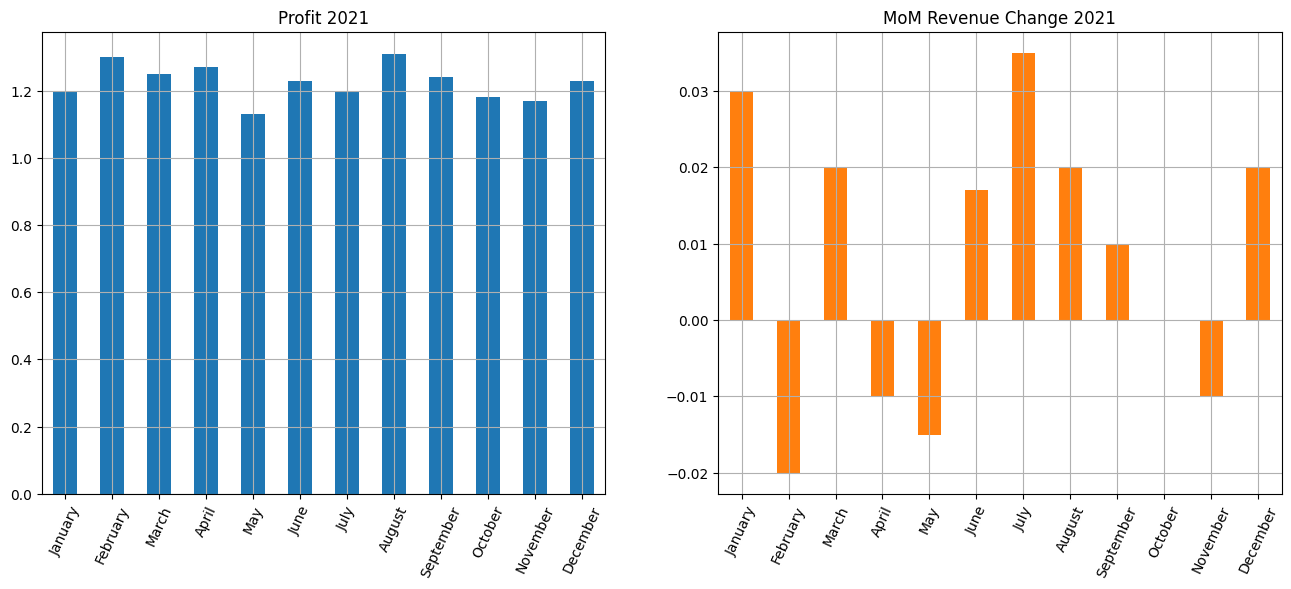

In [31]:
# построим графики для размера прибыли и изменения выручки за месяц
financials[['profit', 'MoM']].plot(subplots = True,       # обозначим, что хотим несколько подграфиков
                                   layout = (1,2),        # зададим сетку
                                   kind = 'bar',          # укажем тип диаграммы
                                   rot = 65,              # повернем деления шкалы оси x
                                   grid = True,           # добавим сетку
                                   figsize = (16, 6),     # укажем размер figure
                                   legend = False,        # уберем легенду
                                   title = ['Profit 2021', 'MoM Revenue Change 2021']); # добавим заголовки

# Пропущенные значения

В  данных встречаются не только ошибки, но и пропущенные значения (missing values). При этом не все алгоритмы машинного обучения умеют работать с данными, в которых есть пропуски.

**Типы пропусков**

В 1976 году математик Дональд Рубин (Donald B. Rubin) предложил следующую классификацию пропущенных значений.

**Полностью случайные пропуски**

Полностью случайные пропуски (missing completely at random, MCAR) предполагают, что вероятность появления пропуска никак не связана с данными. Такие пропуски возникают, например, если измерительный прибор неисправен и случайным образом не записал часть наблюдений, или если один из образцов крови, изучаемых в лаборатории, оказался поврежден и по этой причине его характеристики выпали из исследования.

**Случайные пропуски**

Случайные пропуски (missing at random, MAR) — вероятность появления пропуска зависит от некоторой известной нам переменной. Например, отсутствие ответа на определенный вопрос анкеты может зависеть от возраста респондента. Молодые охотнее отвечают на вопрос, люди более пожилого возраста скорее избегают ответа.

Если мы знаем об этой особенности, то можем, правильно собирая и корректируя данные, добиться большей объективности.

**Неслучайные пропуски**

Неслучайные пропуски (missing not at random, MNAR) — вероятность появления пропуска зависит, в том числе, от фактора, о котором мы ничего не знаем. Например, у весов может быть верхний предел измерения и любой образец выше этого предела автоматически не записывается. В опросах общественного мнения MNAR возникает, когда люди с более активной жизненной позицией (переменная, которую мы не измеряем) чаще дают ответы на вопросы интервьюера.

In [32]:
# импортируем датасет Титаник
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X.drop(['boat', 'body', 'home.dest'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [33]:
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
727,3.0,"Connors, Mr. Patrick",male,70.5,0.0,0.0,370369,7.7500,None,Q
51,1.0,"Carlsson, Mr. Frans Olof",male,33.0,0.0,0.0,695,5.0000,B51 B53 B55,S
239,1.0,"Roebling, Mr. Washington Augustus II",male,31.0,0.0,0.0,PC 17590,50.4958,A24,S
1064,3.0,"Niskanen, Mr. Juha",male,39.0,0.0,0.0,STON/O 2. 3101289,7.9250,None,S
69,1.0,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0.0,1.0,113505,55.0000,E33,S


In [34]:
titanic = X_train.copy()
titanic.head(2)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
727,3.0,"Connors, Mr. Patrick",male,70.5,0.0,0.0,370369,7.75,None,Q
51,1.0,"Carlsson, Mr. Frans Olof",male,33.0,0.0,0.0,695,5.00,B51 B53 B55,S


In [35]:
type(X_train)

pandas.core.frame.DataFrame

## Выявление пропусков

### Базовые методы

В первую очередь, можно использовать метод .info(). Этот метод соотносит максимальное количество записей в датафрейме с количеством записей в каждом столбце.

#### Метод `.info()`

In [36]:
# метод .info() соотносит максимальное количество записей с количеством записей в каждом столбце
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047 entries, 727 to 65
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1047 non-null   float64 
 1   name      1047 non-null   object  
 2   sex       1047 non-null   category
 3   age       841 non-null    float64 
 4   sibsp     1047 non-null   float64 
 5   parch     1047 non-null   float64 
 6   ticket    1047 non-null   object  
 7   fare      1046 non-null   float64 
 8   cabin     230 non-null    object  
 9   embarked  1045 non-null   category
dtypes: category(2), float64(5), object(3)
memory usage: 75.9+ KB


Столбец Age логично преобразовать в тип int, однако из-за того, что в нем есть пропущенные значения, сделать этого не получится. Для количественных данных с пропусками доступен только тип float.

In [37]:
# попробуем преобразовать Age в int
# titanic.Age.astype('int')

Если столбцов много, результат метода .info() становится трудно воспринимать.


Можно последовательно использовать методы .isna() и .sum().

#### Методы `.isna()` и `.sum()`

In [38]:
# .isna() выдает True или 1, если есть пропуск, .sum() суммирует единицы по столбцам
titanic.isna().sum()

pclass        0
name          0
sex           0
age         206
sibsp         0
parch         0
ticket        0
fare          1
cabin       817
embarked      2
dtype: int64

In [39]:
# пропущенные значения в процентах
(titanic.isna().sum() / len(titanic)).round(4) * 100

pclass       0.00
name         0.00
sex          0.00
age         19.68
sibsp        0.00
parch        0.00
ticket       0.00
fare         0.10
cabin       78.03
embarked     0.19
dtype: float64

### Библиотека missingno

Библиотека missingno предоставляет удобные средства для визуальной оценки пропусков.

In [40]:
# импортируем библиотеку missingno с псевдонимом msno
import missingno as msno

In [41]:
# сделаем стиль графиков seaborn основным
sns.set()

#### Столбчатая диаграмма пропусков

В первую очередь на пропуски можно посмотреть с помощью столбчатой диаграммы (функция msno.bar()).

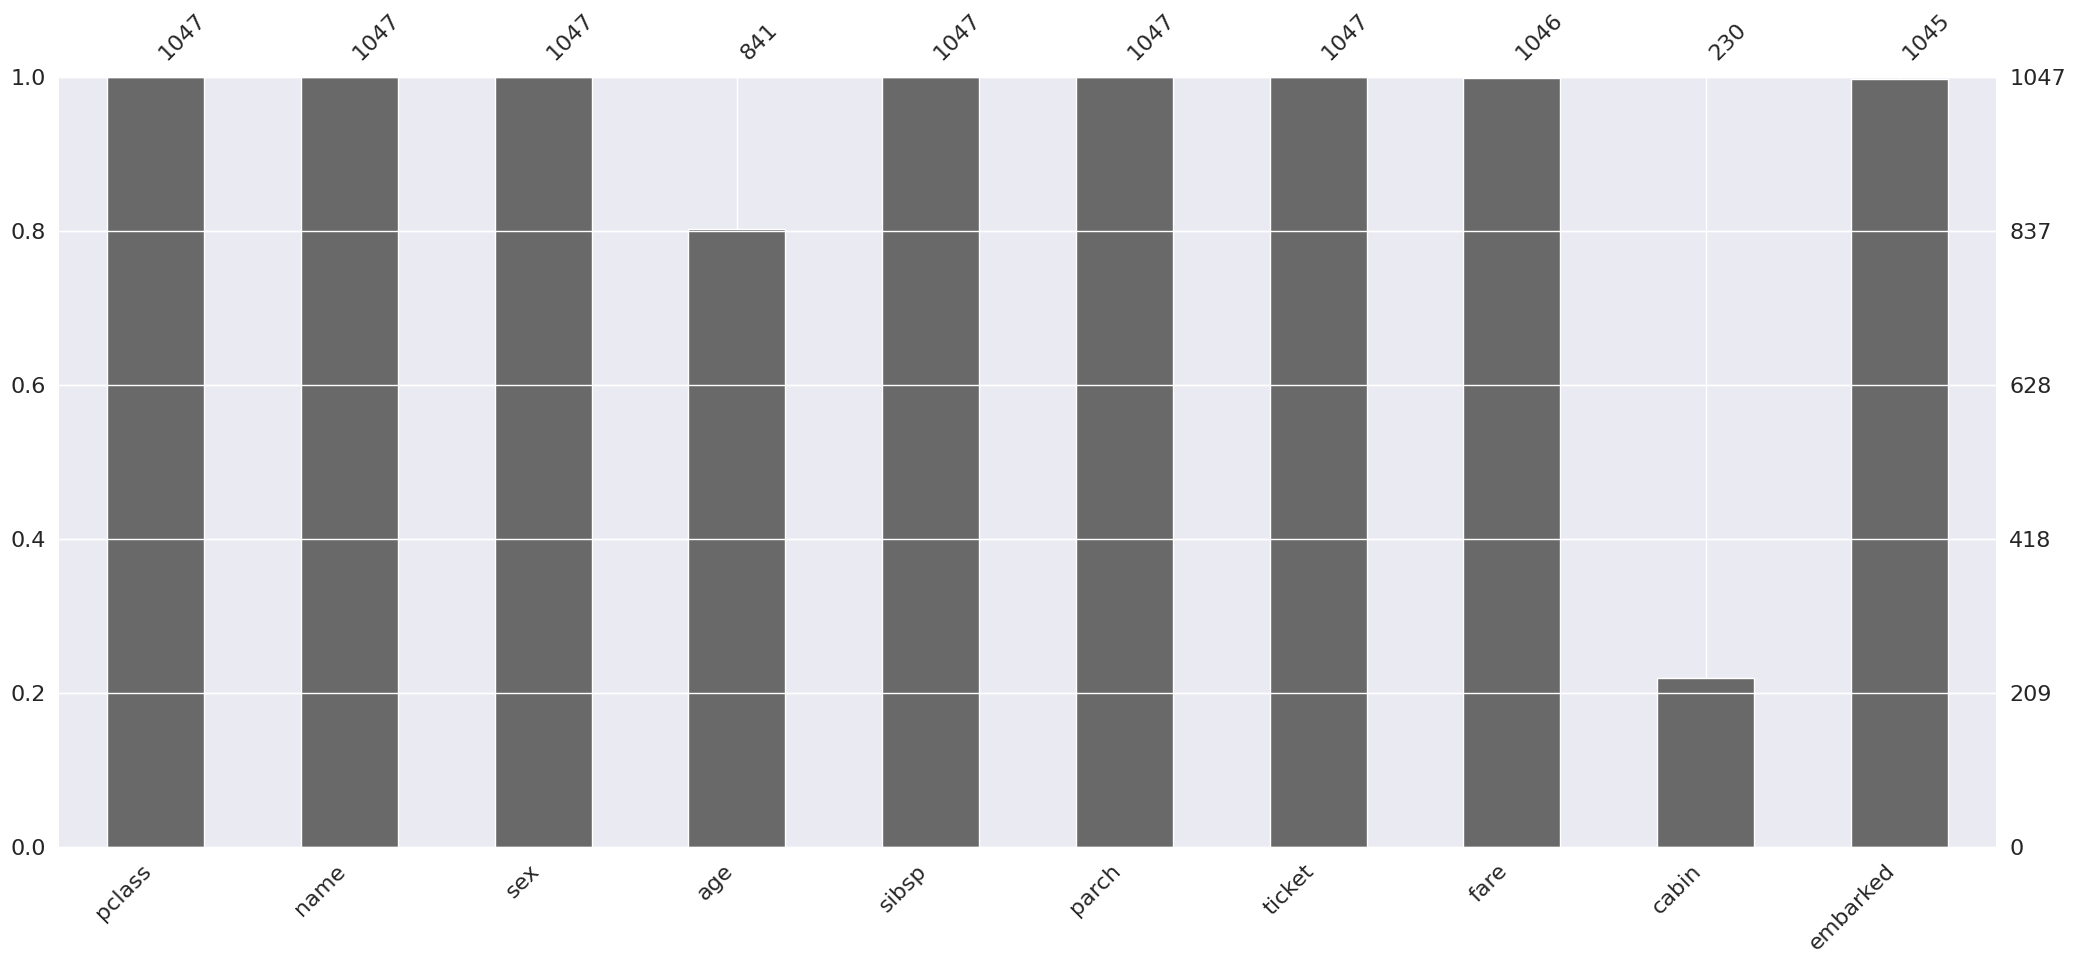

In [42]:
msno.bar(titanic);

На этом графике  видим процент (слева) и абсолютное количество (справа и сверху) заполненных значений.

При этом столбчатая диаграмма не дает информации о том, где именно больше всего пропущенных значений. Другими словами, есть ли в пропусках какая-то закономерность или нет.

Для этого подойдет матрица пропущенных значений (функция msno.matrix()).

#### Матрица пропущенных значений

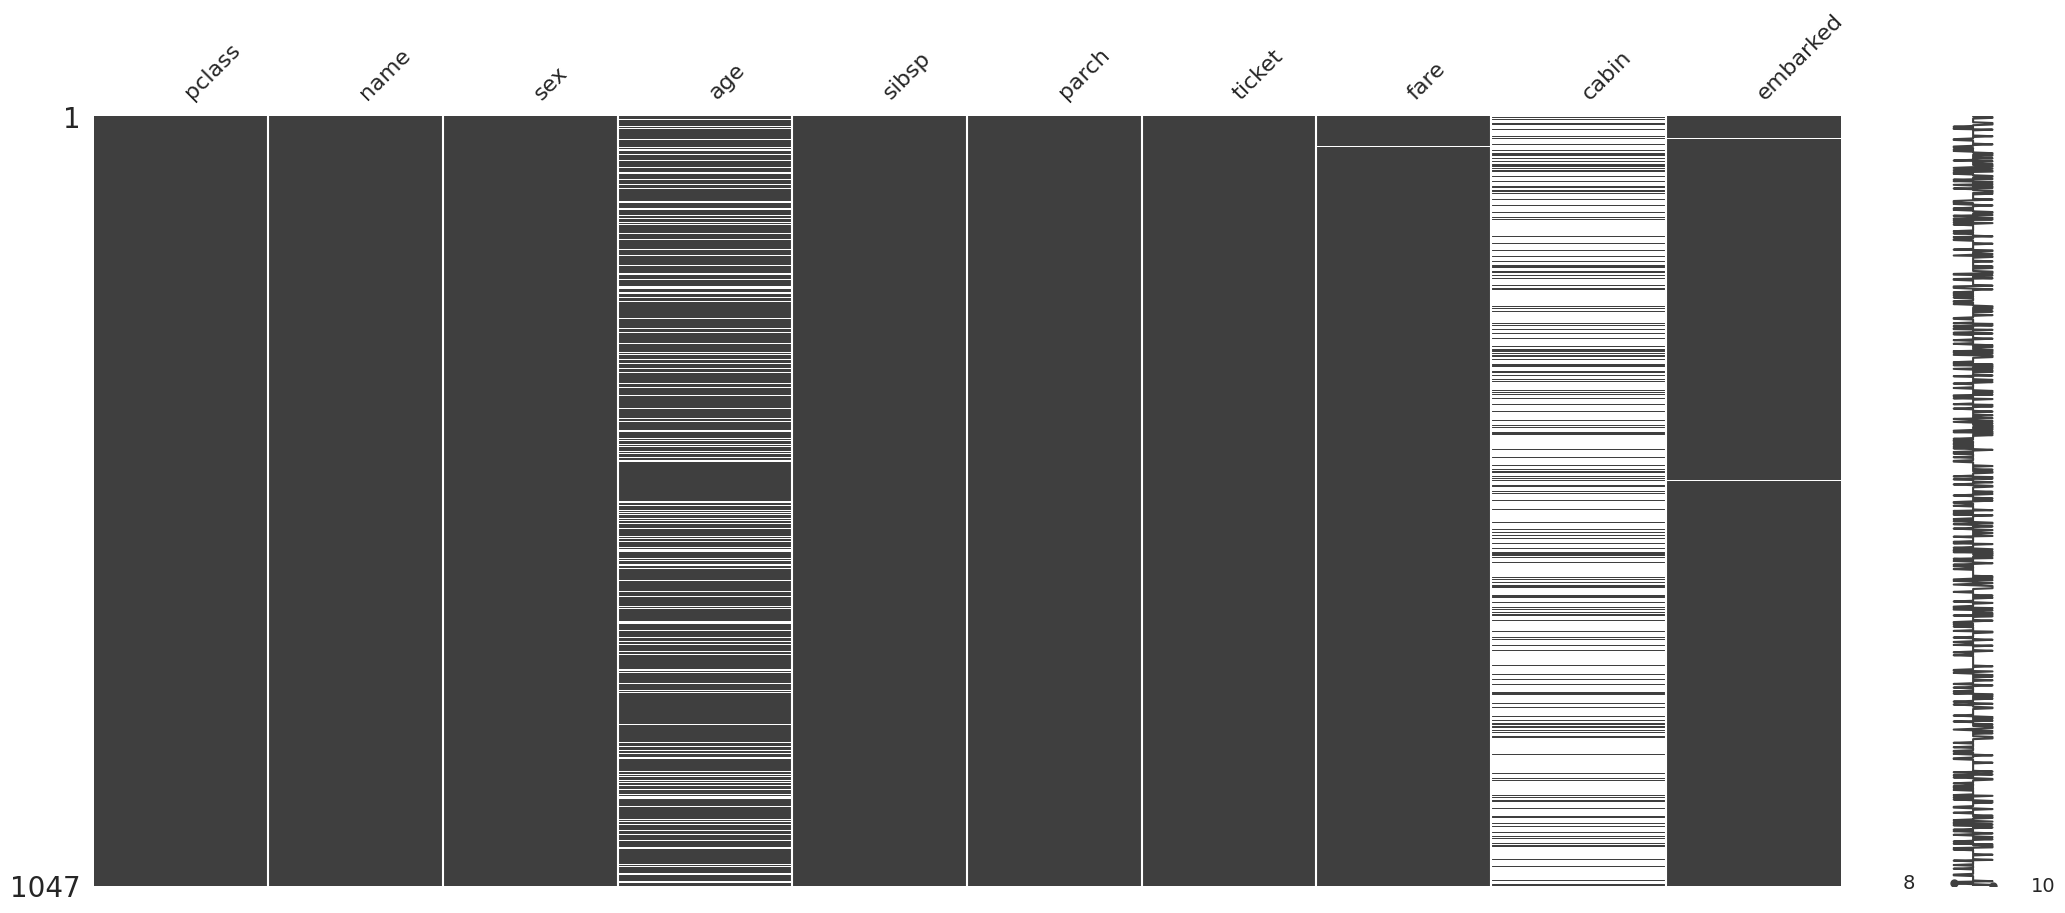

In [43]:
msno.matrix(titanic);

Распределение пропущенных значений в датасете «Титаник» выглядит случайным, закономерностью были бы пропуски, например, только в первой половине наблюдений.

При этом обратите внимание, мы говорим про случайность внутри столбцов с пропусками. О том, зависят ли пропуски от значений других столбцов, мы поговорим ниже.

#### Матрица корреляции пропусков

Еще один  инструмент — матрица корреляции пропущенных значений (nullity correlation matrix).

По сути, она показывает насколько сильно присутствие или отсутствие значений одного признака влияет на присутствие значений другого.

Если мы знаем, в каких столбцах есть пропуски, то можем просто последовательно применить к ним методы .isnull() и .corr().

In [44]:
# рассчитаем матрицу корреляции, когда известно в каких столбцах были пропуски
titanic[['age', 'cabin', 'embarked']].isnull().corr()

,age,cabin,embarked
age,1.000000,0.146540,-0.021652
cabin,0.146540,1.000000,-0.082453
embarked,-0.021652,-0.082453,1.000000


В тех случаях, когда мы не знаем, в каких столбцах есть пропущенные значения, то можем использовать код ниже

In [45]:
# код для случаев, когда столбцы с пропусками не известны
df = titanic.iloc[:, [i for i, n in enumerate(np.var(titanic.isnull(), axis = 'rows')) if n > 0]]
df.isnull().corr()

,age,fare,cabin,embarked
age,1.000000,-0.015303,0.146540,-0.021652
fare,-0.015303,1.000000,0.016405,-0.001353
cabin,0.146540,0.016405,1.000000,-0.082453
embarked,-0.021652,-0.001353,-0.082453,1.000000


Значения корреляции могут быть от −1 (если значения одного признака присутствуют, значения другого — отсутствуют) до 1 (если присутствуют значения одного признака, то присутствуют значения и другого).

Визуально, корреляцию пропущенных значений можно представить с помощью тепловой карты (heatmap). Для этого есть функция msno.heatmap().

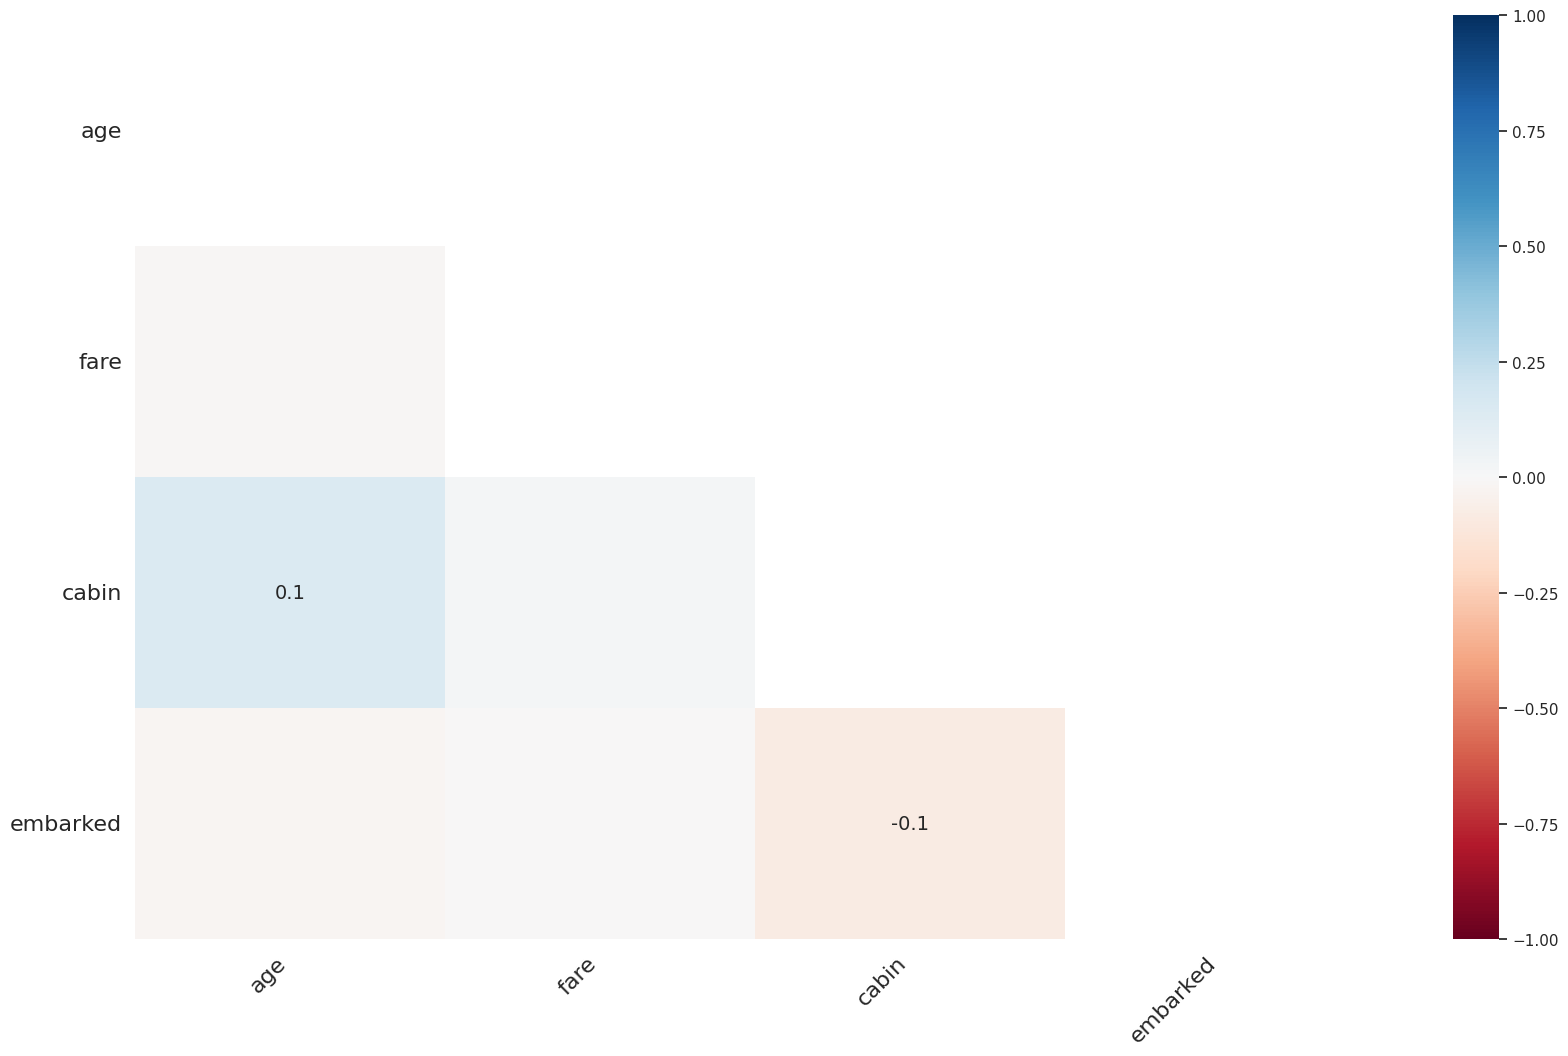

In [46]:
msno.heatmap(titanic);

Мы видим, что корреляция пропусков близка к нулю для всех признаков. Другими словами, пропуски одного признака не влияют на пропуски другого.

Теперь рассмотрим стратегии работы с пропусками. По большому счету их две: удаление и заполнение. У обоих подходов есть свои достоинства и недостатки.

## Удаление пропусков

Во многих случаях удаление пропусков (missing values deletion) может оказаться неплохим решением, потому что в этом случае мы не «портим» данные.

Удаление пропущенных значений хорошо работает (позволяет качественно обучить алгоритм), если мы считаем, что пропуски носят полностью случайный характер (MCAR). Единственным ограничением в этом случае будет достаточность данных для обучения после удаления пропусков.

### Удаление строк

Удаление строк (deleting rows или listwise deletion, также называется анализом полных наблюдений, complete case analysis), в которых есть пропуски — наиболее очевидный подход к работе с пропущенными значениями. Рассмотрим этот способ на практике.

В датасете «Титаник» мало пропущенных значения в столбце Embarked. Удалим соответствующие строки.

In [47]:
# удаление строк обозначим через axis = 'index'
# subset = ['embarked'] говорит о том, что мы ищем пропуски только в столбце Embarked
titanic.dropna(axis = 'index', subset = ['embarked'], inplace = True)

In [48]:
# убедимся, что в Embarked действительно не осталось пропусков
titanic.embarked.isna().sum()

0

Удаление строк не стоит применять, если пропущенные значения зависят от какого-либо неизвестного нам фактора (MNAR). Например, если на вопрос анкеты не склонны отвечать менее активные граждане, удаление строк с пропусками оставит в данных только определенную группу населения (появится bias, искажение) и алгоритм не будет репрезентативен.

Кроме того, если в одном из столбцов большой процент пропусков, построчное удаление просто оставит нас без данных. В датасете «Титаник» это относится к столбцу Cabin. В этом случае, если мы выбираем стратегию удаления данных, разумнее удалить сам столбец.

### Удаление столбцов

Удаление столбцов (column deletion) несложно выполнить с помощью метода .drop(). Например, удалим столбец Cabin, в котором много пропусков.

In [49]:
# передадим в параметр columns тот столбец, который хотим удалить
titanic.drop(columns = ['cabin'], inplace = True)

In [50]:
# убедимся, что такого столбца больше нет
titanic.columns

Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'embarked'],
      dtype='object')

### Pairwise deletion

Попарное удаление пропусков (pairwise deletion или, как еще говорят, анализ доступных данных, available case analysis) проще понять, если представить, что мы не удаляем пропуски, а игнорируем их или используем только доступные значения.

Расчет метрик. Принципа игнорирования пропусков придерживаются очень многие функции и методы в Питоне. Например, используем методы .groupby() и .count() для того, чтобы посчитать количество мужчин и женщин на борту и выведем данные по каждому из оставшихся признаков.

In [51]:
# рассчитаем количество мужчик и женщин по каждому из признаков
sex_g = titanic.groupby('sex').count()
sex_g

,pclass,name,age,sibsp,parch,ticket,fare,embarked
sex,,,,,,,,
female,368,368,305,368,368,368,368,368
male,677,677,534,677,677,677,676,677


Как вы видите, если верить столбцу Age, пассажиров на борту меньше, чем если руководствоваться данными

In [52]:
# сравним количество пассажиров в столбце age и столбце name
# мы видим, что метод .count() игнорировал пропуски
sex_g['name'].sum(), sex_g['age'].sum()

(1045, 839)

Это значит, что метод .count() игнорировал пропуски. То же самое касается, например, метода .mean() или метода .corr().

In [53]:
# метод .mean() также игнорирует пропуски и не выдает ошибки
titanic['age'].mean()

29.97218915375447

In [54]:
# то же можно сказать про метод .corr()
titanic[['age', 'fare']].corr()

,age,fare
age,1.000000,0.188331
fare,0.188331,1.000000


## Заполнение пропусков

удаление пропусков не всегда возможно. В этом случае прибегают к заполнению пропусков (missing values imputation). Подготовим данные.

Подготовка данных

In [55]:
# еще раз загрузим датасет "Титаник", в котором снова будут пропущенные значения
titanic = X_train.copy()


# возьмем лишь некоторые из столбцов
titanic = titanic[['pclass', 'sex', 'sibsp', 'parch', 'fare', 'age', 'embarked']]

# закодируем столбец Sex с помощью числовых значений
map_dict = {'male' : 0, 'female' : 1}
titanic['sex'] = titanic['sex'].map(map_dict)

# посмотрим на результат
titanic.head()

,pclass,sex,sibsp,parch,fare,age,embarked
727,3.0,0,0.0,0.0,7.7500,70.5,Q
51,1.0,0,0.0,0.0,5.0000,33.0,S
239,1.0,0,0.0,0.0,50.4958,31.0,S
1064,3.0,0,0.0,0.0,7.9250,39.0,S
69,1.0,1,0.0,1.0,55.0000,NaN,S


### Одномерные методы

Одномерные методы (Single Imputation) — это заполнение с использованием данных одного столбца. Другими словами, чтобы заполнить пропуски мы берем данные того же признака.

#### Заполнение константой

Количественные данные. Самый простой способ работы с пропусками в количественных данных — заполнить пропуски константой. Например, нулем (подходит для алгоритмов, чувствительных к масштабу признаков).

Метод `.fillna()`

Количественные данные

In [56]:
# вначале сделаем копию датасета
fillna_const = titanic.copy()

# заполним пропуски в столбце Age нулями, передав методу .fillna() словарь,
# где ключами будут названия столбцов, а значениями - константы для заполнения пропусков
fillna_const.fillna({'age' : 0}, inplace = True)

Заполнение константой позволяет не сокращать размер выборки, однако может внести системную ошибку в данные. Сравним медианный возраст до и после заполнения пропусков нулями.

In [57]:
# посмотрим, как такое заполнение отразилось на данных
titanic.age.median(), fillna_const.age.median()

(28.0, 24.0)

При использовании алгоримов, основанных на деревьях решений, пропуски можно заполнить значением, не встречающимся в выборке. Если все значения признака положительные, то пропуски заполняются, например, −1.

Категориальные данные

Для категориальных признаков в некоторых случаях можно провести дополнительное исследование. В частности, в датасете «Титаник» есть два пассажира с неизвестным портом посадки.

In [58]:
# найдем пассажиров с неизвестным портом посадки
# для этого создадим маску по столбцу Embarked и применим ее к исходным данным
missing_embarked = titanic.copy()
missing_embarked[missing_embarked.embarked.isnull()]

,pclass,sex,sibsp,parch,fare,age,embarked
284,1.0,1,0.0,0.0,80.0,62.0,NaN
168,1.0,1,0.0,0.0,80.0,38.0,NaN


При этом  можно найти информацию о том, что обе пассажирки (Mrs Stone и ее служанка Amelie Icard) зашли на борт в порту Southampton (S).

Для заполнения строковым значением также подойдет метод .fillna().

In [59]:
# метод .fillna() можно применить к одному столбцу
# два пропущенных значения в столбце Embarked заполним буквой S (Southampton)
fillna_const.embarked.fillna('S', inplace = True)

In [60]:
# убедимся, что в столбцах Age и Embarked не осталось пропущенных значений
fillna_const[['age', 'embarked']].isna().sum()

age         0
embarked    0
dtype: int64

 Что делать, если пропуски заполнены каким-либо символом, а не NaN? Например, знаком вопроса.

In [61]:
df = pd.DataFrame([[1, 2, 3],
                   ['?', 5, 6],
                   [7, '?', 9]])

df

,0,1,2
0,1,2,3
1,?,5,6
2,7,?,9


In [62]:
df[df == '?'] = np.nan
df

,0,1,2
0,1,2,3
1,NaN,5,6
2,7,NaN,9


SimpleImputer

Вместо метода .fillna() можно использовать инструмент библиотеки sklearn, который называется SimpleImputer. Создадим объект этого класса и обучим модель.

In [63]:
# сделаем копию датасета
const_imputer = titanic.copy()

# импортируем класс SimpleImputer из модуля impute библиотеки sklearn
from sklearn.impute import SimpleImputer

# создадим объект этого класса, указав,
# что мы будем заполнять константой strategy = 'constant', а именно нулем fill_value = 0
imp_const = SimpleImputer(strategy = 'constant', fill_value = 0)

# и обучим модель на столбце Age
# мы используем двойные скобки, потому что метод .fit() на вход принимает двумерный массив
imp_const.fit(const_imputer[['age']])

SimpleImputer(fill_value=0, strategy='constant')

Теперь применим эту модель для заполнения пропусков.

In [64]:
# также используем двойные скобки с методом .transform()
const_imputer['age'] = imp_const.transform(const_imputer[['age']])

# убедимся, что пропусков не осталось и посчитаем количество нулевых значений
const_imputer.age.isna().sum(), (const_imputer['age'] == 0).sum()

(0, 206)

В конце раздела мы проведем сравнение эффективности различных методов заполнения пропусков и столбец Embarked нам уже не понадобится.

In [65]:
# для дальнейшей работы столбец Embarked нам не понадобится, удалим его
const_imputer.drop(columns = ['embarked'], inplace = True)

# посмотрим на размер получившегося датафрейма
const_imputer.shape

(1047, 6)

In [66]:
# посмотрим на результат
const_imputer.head(3)

,pclass,sex,sibsp,parch,fare,age
727,3.0,0,0.0,0.0,7.7500,70.5
51,1.0,0,0.0,0.0,5.0000,33.0
239,1.0,0,0.0,0.0,50.4958,31.0


#### Заполнение средним арифметическим или медианой

Количественные данные можно заполнить средним арифметическим или медианой (Statistical Imputation). Вначале воспольуемся методом .fillna().

Метод `.fillna()`

In [67]:
# сделаем копию датафрейма
fillna_median = titanic.copy()

# заполним пропуски в столбце Age медианным значением возраста,
# можно заполнить и средним арифметическим через метод .mean()
fillna_median.age.fillna(fillna_median.age.median(), inplace = True)

# убедимся, что пропусков не осталось
fillna_median.age.isna().sum()

0

У такого простого и понятного подхода тем не менее есть ряд недостатков.

когда в данных появляется большое количество одинаковых близких к среднему значений, мы снижаем ценную вариативность в данных.
Кроме того, такое заполнение пропусков может быть некорректно.

SimpleImputer

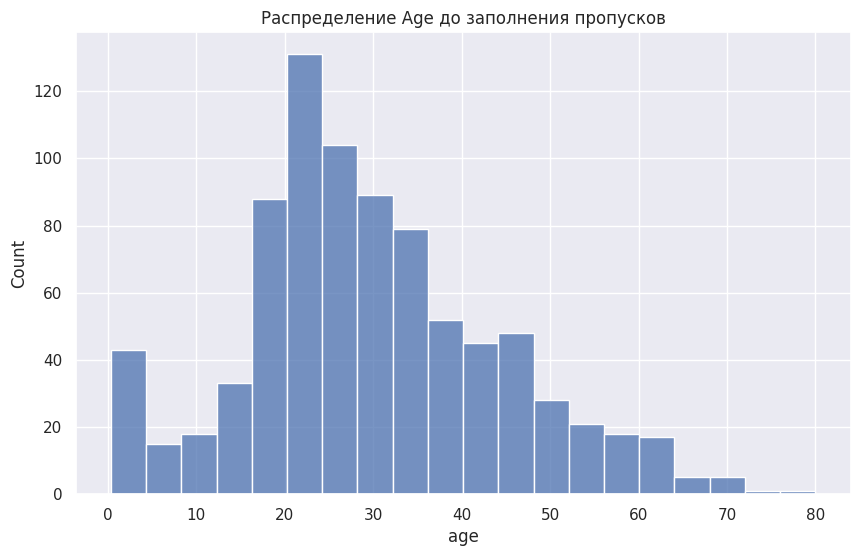

In [68]:
# изменим размер последующих графиков
sns.set(rc = {'figure.figsize' : (10, 6)})

# скопируем датафрейм
median_imputer = titanic.copy()

# посмотрим на распределение возраста до заполнения пропусков
sns.histplot(median_imputer['age'], bins = 20)
plt.title('Распределение Age до заполнения пропусков');

Посмотрим на среднее арифметическое и медиану.



In [69]:
# посмотрим на среднее арифметическое и медиану
median_imputer['age'].mean().round(1), median_imputer['age'].median()

(30.0, 28.0)

Используем класс SimpleImputer библиотеки sklearn для заполнения пропусков этим медианным значением.

In [70]:
# создадим объект класса SimpleImputer с параметром strategy = 'median'
# (для заполнения средним арифметическим используйте strategy = 'mean')
imp_median = SimpleImputer(strategy = 'median')

# применим метод .fit_transform() для одновременного обучения модели и заполнения пропусков
median_imputer['age'] = imp_median.fit_transform(median_imputer[['age']])

# убедимся, что пропущенных значений не осталось
median_imputer.age.isna().sum()

0

Посмотрим на распределение возраста и его медианное значение после заполнения пропусков.

 распределение притерпело существенные изменения. В частности, у нас появилось очень много медианных значений, которые доминируют в распределении возраста.

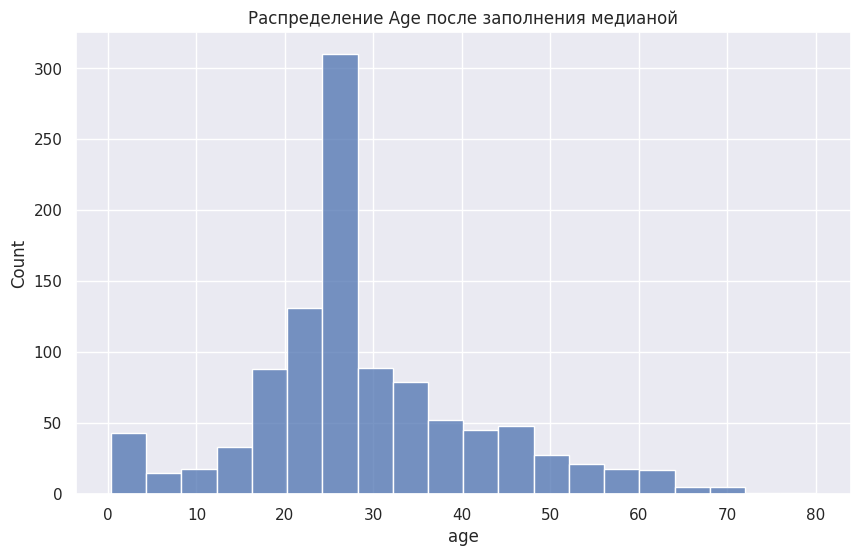

In [71]:
# посмотрим на распределение после заполнения пропусков
sns.histplot(median_imputer['age'], bins = 20)
plt.title('Распределение Age после заполнения медианой');

In [72]:
# посмотрим на метрики после заполнения медианой
median_imputer['age'].mean().round(1), median_imputer['age'].median()

(29.6, 28.0)

In [73]:
# столбец Embarked нам опять же не понадобится
median_imputer.drop(columns = ['embarked'], inplace = True)

# посмотрим на размеры получившегося датафрейма
median_imputer.shape

(1047, 6)

#### Заполнение внутригрупповым значением

Справиться с этой проблемой можно, в частности, через более сложный способ заполнения пропусков количественного признака — вначале разбить пассажиров на категории (bins), например, по полу или классу каюты, вычислить медианное значение для каждой категории и только потом заполнять им пропущенные значения.

Выполним группировку с помощью метода .groupby() и найдем медианный возраст каждой группы.

In [74]:
# скопируем датафрейм
median_imputer_bins = titanic.copy()

In [75]:
# сгруппируем пассажиров по полу и классу каюты
Age_bins = median_imputer_bins.groupby(['sex', 'pclass'])

# найдем медианный возраст с учетом получившихся групп
Age_bins.age.median()

sex  pclass
1    1.0       36.0
     2.0       26.5
     3.0       22.5
0    1.0       42.0
     2.0       30.0
     3.0       25.0
Name: age, dtype: float64

Применим lambda-функцию к объекту SeriesGroupBy и заменим пропуски соответствующим медианным значением.

In [76]:
# возьмем объект SeriesGroupBy (он в переменной Age_bins.Age)
# и применим к нему lambda-функцию через метод .apply()
median_imputer_bins.Age = Age_bins.age.apply(lambda x: x.fillna(x.median()))

<ipython-input-76-97f3b8f10745>:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  median_imputer_bins.Age = Age_bins.age.apply(lambda x: x.fillna(x.median()))
<ipython-input-76-97f3b8f10745>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  median_imputer_bins.Age = Age_bins.age.apply(lambda x: x.fillna(x.median()))


Убедимся, что в столбце Age не осталось пропусков

In [77]:
# проверим пропуски в столбце Age
median_imputer_bins.age.isna().sum()

206

In [78]:
# столбец Embarked нам опять же не понадобится
median_imputer_bins.drop(columns = ['embarked'], inplace = True)

# посмотрим на размеры получившегося датафрейма
median_imputer_bins.shape

(1047, 6)

Мы видим, что медианное значение доминирует гораздо меньше.

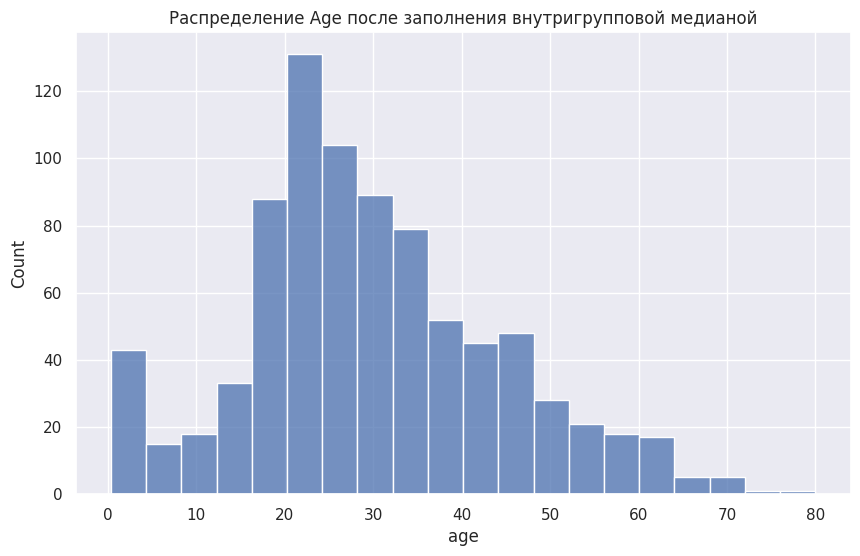

In [79]:
sns.histplot(median_imputer_bins['age'], bins = 20)
plt.title('Распределение Age после заполнения внутригрупповой медианой');

#### Заполнение наиболее частотным значением

Для заполнения пропусков в категориальных данных подойдет метод заполнения наиболее часто встречающимся значением (модой). Если пропусков немного, этот метод вполне обоснован. При большом количестве пропусков, можно попробовать создать на их основе новую категорию.

Подготовим данные и посмотрим на распределение категорий в столбце Embarked.

In [80]:
# скопируем датафрейм
titanic_mode = titanic.copy()

# посмотрим на распределение пассажиров по порту посадки до заполнения пропусков
titanic_mode.groupby('embarked')['sex'].count()

embarked
C    205
Q    100
S    740
Name: sex, dtype: int64

Модой будет порт Southampton (что одновременно является верным для заполнения пропусков значением, однако, опять же, в большинстве случаев мы не можем этого знать наверняка).

Воспользуемся классом SimpleImputer для заполнения пропусков.

In [81]:
# создадим объект класса SimpleImputer с параметром strategy = 'most_frequent'
imp_most_freq = SimpleImputer(strategy = 'most_frequent')

# применим метод .fit_transform() к столбцу Embarked
titanic_mode['embarked'] = imp_most_freq.fit_transform(titanic_mode[['embarked']])

# убедимся, что пропусков не осталось
titanic_mode.embarked.isna().sum()

0

Проверим результат.

In [82]:
# проверим результат
# количество пассажиров в категории S должно увеличиться на два
titanic_mode.groupby('embarked')['sex'].count()

embarked
C    205
Q    100
S    742
Name: sex, dtype: int64

еще один простой способ найти моду. Его можно использовать совместно с методом .fillna() для заполнения пропусков.

In [83]:
# простой способ найти моду
titanic.embarked.value_counts().index[0]

'S'

В случае если у нас есть существенное количество пропусков в категориальной переменной мы можем задуматься над созданием отдельной категории для пропущенных значений.

In [84]:
# для работы с последующими методами столбец Embarked нам уже не нужен
titanic.drop(columns = ['embarked'], inplace = True)

### Многомерные методы

Более продвинутый подход — многомерные методы (Multivariate Imputation), заполнение пропусков одной переменной на основе данных других признаков. Другими словами,  строим модель машинного обучения для заполнения пропусков.


Такой моделью может быть линейная регрессия для количественных признаков или логистическая — для категориальных.

Обратите внимание, что хотя технически мы могли бы использовать исходную целевую переменную в качестве одного из признаков для заполнения пропусков, делать этого не стоит, потому что в этом случае мы создадим между ними взаимосвязь, которой изначально могло не быть.

Рассмотрим пример линейной регрессии и сразу два подхода к ее реализации, детерминированный и стохастический.

#### Линейная регрессия

##### Детерминированный подход

Детерминированный подход (deterministic approach) предполагает, что мы заполняем пропуски строго теми значениями, которые будут предсказаны линейной регрессией.

Подготовка данных

In [85]:
# сделаем копию датасета
lr = titanic.copy()

# импортируем класс StandardScaler модуля Preprocessing библиотеки sklearn
from sklearn.preprocessing import StandardScaler

# создаем объект этого класса
scaler = StandardScaler()

# применяем метод .fit_transform() и сразу помещаем результат в датафрейм
lr = pd.DataFrame(scaler.fit_transform(lr), columns = lr.columns)

# посмотрим на результат
lr.head(3)

,pclass,sex,sibsp,parch,fare,age
0,0.841508,-0.739276,-0.471246,-0.436815,-0.483953,2.776386
1,-1.552674,-0.739276,-0.471246,-0.436815,-0.536292,0.204400
2,-1.552674,-0.739276,-0.471246,-0.436815,0.329593,0.067227


В тестовую выборку мы поместим те наблюдения, в которых в столбце Age есть пропуски.

In [86]:
# поместим в датафрейм test те строки, в которых в столбце Age есть пропуски
test = lr[lr['age'].isnull()].copy()
test.head(3)

,pclass,sex,sibsp,parch,fare,age
4,-1.552674,1.352675,-0.471246,0.678661,0.415318,NaN
14,0.841508,-0.739276,-0.471246,-0.436815,-0.483953,NaN
16,-0.355583,-0.739276,-0.471246,-0.436815,-0.631452,NaN


In [87]:
# посмотрим на количество таких строк
test.shape

(206, 6)

В обучающей выборке напротив окажутся те строки, где в Age пропусков нет.

In [88]:
# в train напротив окажутся те строки, где в Age пропусков нет
train = lr.dropna().copy()

# оценим их количество
train.shape

(840, 6)

In [89]:
# вместе train + test
len(train) + len(test)

1046

Из датафрейма train выделим столбец Age. Это будет наша целевая переменная.

In [90]:
# из датафрейма train выделим столбец Age, это будет наша целевая переменная
y_train = train['age']

# из датафрейма признаков столбец Age нужно удалить
X_train = train.drop('age', axis = 1)

# в test столбец Age в принципе не нужен
X_test = test.drop('age', axis = 1)

In [91]:
# оценим результаты
X_train.head(3)

,pclass,sex,sibsp,parch,fare
0,0.841508,-0.739276,-0.471246,-0.436815,-0.483953
1,-1.552674,-0.739276,-0.471246,-0.436815,-0.536292
2,-1.552674,-0.739276,-0.471246,-0.436815,0.329593


In [92]:
y_train.head(3)

0    2.776386
1    0.204400
2    0.067227
Name: age, dtype: float64

In [93]:
X_test.head(3)

,pclass,sex,sibsp,parch,fare
4,-1.552674,1.352675,-0.471246,0.678661,0.415318
14,0.841508,-0.739276,-0.471246,-0.436815,-0.483953
16,-0.355583,-0.739276,-0.471246,-0.436815,-0.631452


Обучение модели и заполнение пропусков

In [94]:
# импортируем класс LinearRegression
from sklearn.linear_model import LinearRegression

# создадим объект этого класса
lr_model = LinearRegression()

# обучим модель
lr_model.fit(X_train, y_train)

# применим обученную модель к данным, в которых были пропуски в столбце Age
y_pred = lr_model.predict(X_test)

# посмотрим на первые три прогнозных значения
y_pred[:3]

array([ 0.51863851, -0.1955791 ,  0.29396334])

Пропущенные значения заполнены. Остается обратно «собрать» датафрейм.

In [95]:
# присоединим прогнозные значения возраста к датафрейму test
test['age'] = y_pred
test.head(3)

,pclass,sex,sibsp,parch,fare,age
4,-1.552674,1.352675,-0.471246,0.678661,0.415318,0.518639
14,0.841508,-0.739276,-0.471246,-0.436815,-0.483953,-0.195579
16,-0.355583,-0.739276,-0.471246,-0.436815,-0.631452,0.293963


Теперь у нас есть два датафрейма train и test со столбцом Age с заполненными пропускам

In [96]:
# в train столбец Age присутствовал изначально
train.head(3)

,pclass,sex,sibsp,parch,fare,age
0,0.841508,-0.739276,-0.471246,-0.436815,-0.483953,2.776386
1,-1.552674,-0.739276,-0.471246,-0.436815,-0.536292,0.204400
2,-1.552674,-0.739276,-0.471246,-0.436815,0.329593,0.067227


Соединим их методом «один на другой» с помощью функции pd.concat().

In [97]:
# соединим датафреймы методом "один на другой"
lr = pd.concat([train, test])
lr.head(7)

,pclass,sex,sibsp,parch,fare,age
0,0.841508,-0.739276,-0.471246,-0.436815,-0.483953,2.776386
1,-1.552674,-0.739276,-0.471246,-0.436815,-0.536292,0.204400
2,-1.552674,-0.739276,-0.471246,-0.436815,0.329593,0.067227
3,0.841508,-0.739276,-0.471246,-0.436815,-0.480622,0.615918
5,0.841508,1.352675,-0.471246,-0.436815,-0.493945,1.027435
6,-0.355583,1.352675,1.502332,0.678661,-0.117583,-0.412877
7,0.841508,-0.739276,1.502332,-0.436815,-0.362941,0.753090


 по сравнению с изначальным датафреймом порядок строк нарушился.

In [98]:
# восстановим изначальный порядок строк, отсортировав их по индексу
lr.sort_index(inplace = True)
lr.head(7)

,pclass,sex,sibsp,parch,fare,age
0,0.841508,-0.739276,-0.471246,-0.436815,-0.483953,2.776386
1,-1.552674,-0.739276,-0.471246,-0.436815,-0.536292,0.204400
2,-1.552674,-0.739276,-0.471246,-0.436815,0.329593,0.067227
3,0.841508,-0.739276,-0.471246,-0.436815,-0.480622,0.615918
4,-1.552674,1.352675,-0.471246,0.678661,0.415318,0.518639
5,0.841508,1.352675,-0.471246,-0.436815,-0.493945,1.027435
6,-0.355583,1.352675,1.502332,0.678661,-0.117583,-0.412877


Остается вернуть исходный масштаб.

In [99]:
# вернем исходный масштаб с помощью метода .inverse_transform()
lr = pd.DataFrame(scaler.inverse_transform(lr), columns = lr.columns)

# округлим столбец Age и выведем результат
lr.Age = lr.age.round(1)
lr.head(7)

<ipython-input-99-4f9b2156cb42>:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  lr.Age = lr.age.round(1)


,pclass,sex,sibsp,parch,fare,age
0,3.0,0.0,0.0,0.0,7.7500,70.500000
1,1.0,0.0,0.0,0.0,5.0000,33.000000
2,1.0,0.0,0.0,0.0,50.4958,31.000000
3,3.0,0.0,0.0,0.0,7.9250,39.000000
4,1.0,1.0,0.0,1.0,55.0000,37.581655
5,3.0,1.0,0.0,0.0,7.2250,45.000000
6,2.0,1.0,2.0,1.0,27.0000,24.000000


В данном случае, если метод .fit_transform() вычитает из каждого значения среднее и делит на станд. отклонение,



то метод .inverse_transform() в обратном порядке умножает каждое число на станд. отклонение и прибавляет среднее арифметическое.


Проверим на наших данных. Подставим в формулу  отмасштабированное значение возраста первого наблюдения (индекс 0).

In [100]:
# восстановив значение возраста первого наблюдения вручную
(0.310144 * titanic.age.std() + titanic.age.mean()).round()

35.0

In [101]:
# убедимся в отсутствии пропусков и посмотрим на размеры получившегося датафрейма
lr.Age.isna().sum(), lr.shape

(0, (1046, 6))

Оценка результата

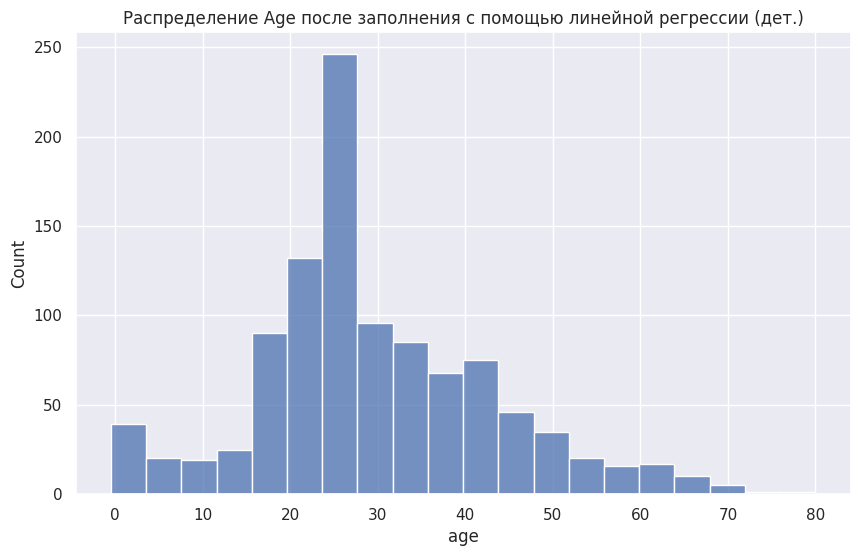

In [102]:
# посмотрим на распределение возраста после заполнения пропусков
sns.histplot(lr['age'], bins = 20)
plt.title('Распределение Age после заполнения с помощью линейной регрессии (дет.)');

распределение чуть больше похоже на нормальное, чем при заполнении медианой.

Впрочем возникла одна проблема. Линейная регрессия предсказала нам отрицательные значения возраста, который разумеется должен быть только положительным. Как поступить? Просто удалить строки с неположительными значениями нам бы не хотелось, чтобы не терять с таким трудом восстановленные данные.

Воспользуемся методом .clip(), который установит минимальную границу значений столбца.

Остается посмотреть на новые средние показатели.

In [103]:
# чтобы возраст был только положительным,
# установим минимальное значение на уровне 0,5
lr.Age.clip(lower = 0.5, inplace = True)

Среднее арифметическое и медиана практически не изменились.

In [104]:
# посмотрим, как изменились среднее арифметическое и медиана
lr.Age.mean().round(1), lr.Age.median()

(29.5, 27.2)

Недостаток детерминированного подхода

В детерминированном подходе сохраняется та же особенность, которую мы наблюдали при заполнении пропусков медианой, а именно доминирование одного значения (в случае медианы) или узкого диапазона (в случае линейной регрессии).

Для того чтобы лучше это увидеть, во-первых, пометим изначальные (назовем их actual) и заполненные (imputed) значения столбца Age.

In [105]:
# сделаем копию датафрейма, которую используем для визуализации
lr_viz = lr.copy()

# создадим столбец Age_type, в который запишем actual, если индекс наблюдения есть в train,
# и imputed, если нет (т.е. он есть в test)
lr_viz['Age_type'] = np.where(lr.index.isin(train.index), 'actual', 'imputed')

# вновь "обрежем" нулевые значения
lr_viz.age.clip(lower = 0.5, inplace = True)

# посмотрим на результат
lr_viz.head(7)

,pclass,sex,sibsp,parch,fare,age,Age_type
0,3.0,0.0,0.0,0.0,7.7500,70.500000,actual
1,1.0,0.0,0.0,0.0,5.0000,33.000000,actual
2,1.0,0.0,0.0,0.0,50.4958,31.000000,actual
3,3.0,0.0,0.0,0.0,7.9250,39.000000,actual
4,1.0,1.0,0.0,1.0,55.0000,37.581655,imputed
5,3.0,1.0,0.0,0.0,7.2250,45.000000,actual
6,2.0,1.0,2.0,1.0,27.0000,24.000000,actual


создадим точечную диаграмму, где по оси x будет индекс датафрейма, по оси y — возраст, а цветом мы обозначим изначальное это значение, или заполненное.

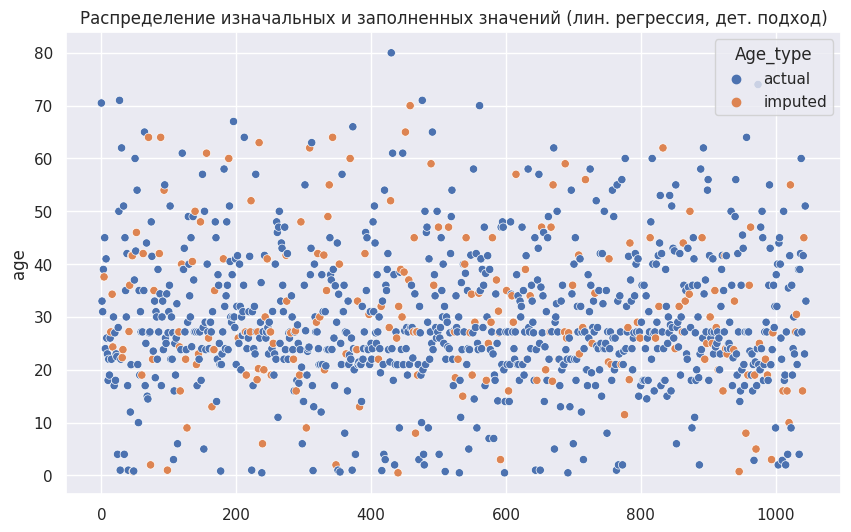

In [106]:
# создадим график, где по оси x будет индекс датафрейма,
# по оси y - возраст, а цветом мы обозначим изначальное это значение, или заполненное
sns.scatterplot(data = lr_viz, x = lr_viz.index, y = 'age', hue = 'Age_type')
plt.title('Распределение изначальных и заполненных значений (лин. регрессия, дет. подход)');

На графике видно, что заполненные значения гораздо ближе к среднему значению (а зачастую просто равны ему), чем исходные данные. Аналогичную картину мы увидим, если рассчитаем соответствующие станд. отклонение

In [107]:
# рассчитаем СКО для исходных и заполненных значений
lr_viz[lr_viz['Age_type'] == 'actual'].age.std().round(2), \
lr_viz[lr_viz['Age_type'] == 'imputed'].age.std().round(2)

(13.21, 14.53)

Можно предположить, что детерминированный подход переоценивает корреляцию между признаками, и, как следствие, преувеличивает точность прогноза пропущенных значений.

Попробуем преодолеть этот недостаток через внесение в заполняемые данные элемента случайности (дополнительных колебаний).

##### Стохастический подход

При применении стохастического подхода (Stochastic Regression Imputation) мы будем использовать гауссовский шум (Gaussian noise), то есть такой шум (элемент случайности), который следует нормальному распределению. Объявим соответствующую функцию.

In [108]:
# объявим функцию для создания гауссовского шума
# на входе эта функция будет принимать некоторый массив значений x,
# среднее значение mu, СКО std и точку отсчета для воспроизводимости результата
def gaussian_noise(x, mu = 0, std = 1, random_state = 42):

  # вначале создадим объект, который позволит получать воспроизводимые результаты
  rs = np.random.RandomState(random_state)

  # применим метод .normal() к этому объекту для создания гауссовского шума
  noise = rs.normal(mu, std, size = x.shape)

  # добавим шум к исходному массиву
  return x + noise

Среднее значение шума, равное нулю, взяли потому, что не хотим искажать колебания в ту или иную сторону. Станд.отклонение равное, по умолчанию, единице указано исходя из того, что в линейной регрессии мы стремимся к работе со стандартизированными данными, отклонение которых как раз равно этой величине.

Заменим заполненные значения теми же значениями, но с добавлением шума

Теперь соединим два датасета исходных и заполненных значений и оценим результат.

In [109]:
# заменим заполненные значения теми же значениями, но с добавлением шума
test['age'] = gaussian_noise(x = test['age'])

# посмотрим, как изменились заполненные значения
test.head(3)

,pclass,sex,sibsp,parch,fare,age
4,-1.552674,1.352675,-0.471246,0.678661,0.415318,1.015353
14,0.841508,-0.739276,-0.471246,-0.436815,-0.483953,-0.333843
16,-0.355583,-0.739276,-0.471246,-0.436815,-0.631452,0.941652


In [110]:
# соединим датасеты и обновим индекс
lr_stochastic = pd.concat([train, test])
lr_stochastic.sort_index(inplace = True)

# вернем исходный масштаб с помощью метода .inverse_transform()
lr_stochastic = pd.DataFrame(scaler.inverse_transform(lr_stochastic), columns = lr_stochastic.columns)

# округлим столбец Age и выведем результат
lr_stochastic.age = lr_stochastic.age.round(1)
lr_stochastic.head(7)

,pclass,sex,sibsp,parch,fare,age
0,3.0,0.0,0.0,0.0,7.7500,70.5
1,1.0,0.0,0.0,0.0,5.0000,33.0
2,1.0,0.0,0.0,0.0,50.4958,31.0
3,3.0,0.0,0.0,0.0,7.9250,39.0
4,1.0,1.0,0.0,1.0,55.0000,44.8
5,3.0,1.0,0.0,0.0,7.2250,45.0
6,2.0,1.0,2.0,1.0,27.0000,24.0


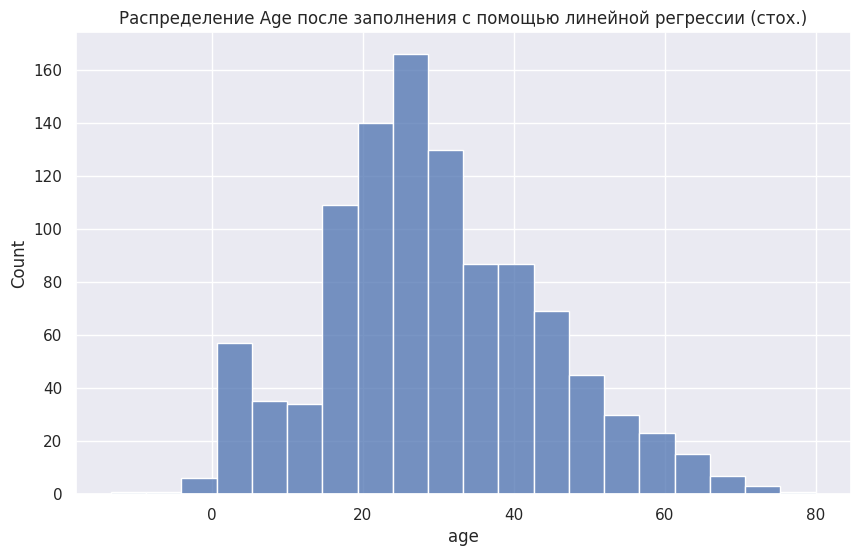

In [111]:
# посмотрим на распределение возраста
# после заполнения пропусков с помощью стохастического подхода
sns.histplot(lr_stochastic['age'], bins = 20)
plt.title('Распределение Age после заполнения с помощью линейной регрессии (стох.)');

распределение еще больше похоже на нормальное.

In [112]:
# обрежем нулевые и отрицательные значения
lr_stochastic.age.clip(lower = 0.5, inplace = True)

Медиана при стохастическом подходе вернулась к значению изначального распределения. Теперь с помощью точечной диаграммы оценим, как изменился разброс заполненных значений.

In [113]:
# посмотрим на среднее арифметическое и медиану
lr_stochastic.age.mean().round(1), lr_stochastic.age.median()

(29.4, 28.0)

разброс заполненных значений существенно приблизился к разбросу изначальных данных

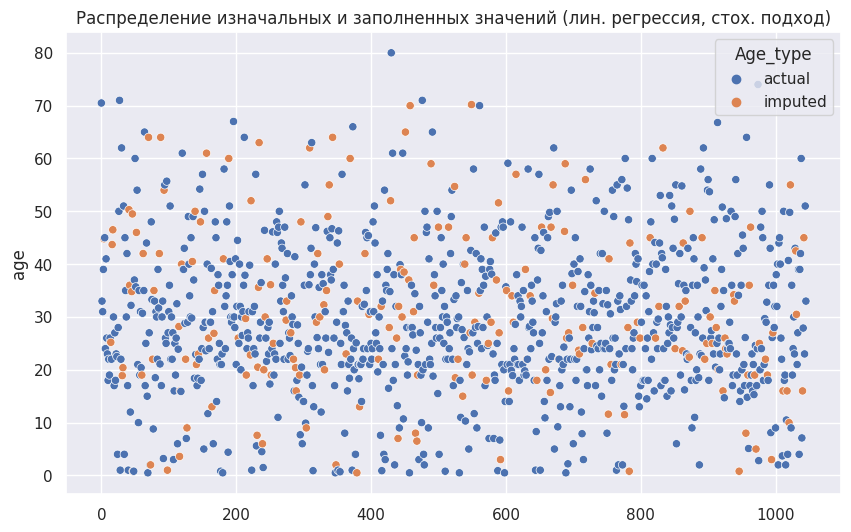

In [114]:
# сделаем копию датафрейма, которую используем для визуализации
lr_st_viz = lr_stochastic.copy()

# создадим столбец Age_type, в который запишем actual, если индекс наблюдения есть в train,
# и imputed, если нет (т.е. он есть в test)
lr_st_viz['Age_type'] = np.where(lr_stochastic.index.isin(train.index), 'actual', 'imputed')

# вновь "обрежем" нулевые значения
lr_st_viz.age.clip(lower = 0.5, inplace = True)

# создадим график, где по оси x будет индекс датафрейма,
# по оси y - возраст, а цветом мы обозначим изначальное это значение, или заполненное
sns.scatterplot(data = lr_st_viz, x = lr_st_viz.index, y = 'age', hue = 'Age_type')
plt.title('Распределение изначальных и заполненных значений (лин. регрессия, стох. подход)');

In [115]:
# рассчитаем СКО для исходных и заполненных значений
lr_st_viz[lr_st_viz['Age_type'] == 'actual'].age.std().round(2), \
lr_st_viz[lr_st_viz['Age_type'] == 'imputed'].age.std().round(2)

(14.43, 15.66)

хотя у нас были основания для разработки стохастического подхода, детерминированный подход будет существенно более точно предсказывать пропуски, поскольку случайные колебания могут как улучшить, так и ухудшить качество заполненных пропусков.

модель логистической регрессии для заполнения пропусков в категориальных данных строится аналогичным образом.

#### MICE / IterativeImputer

Описанный выше алгоритм регрессии используется в алгоритме MICE или IterativeImputer. MICE расшифровывается как Multiple Imputation by Chained Equations, многомерный способ заполнения пропущенных данных с помощью цепных уравнений.

Изначально алгоритм MICE был создан на языке R, но сегодня доступен в качестве экспериментального класса IterativeImputer в библиотеке sklearn.

In [116]:
# сделаем копию датасета для работы с методом MICE
mice = titanic.copy()

In [117]:
# предварительно нам нужно "включить" класс IterativeImputer,
from sklearn.experimental import enable_iterative_imputer
# затем импортировать его
from sklearn.impute import IterativeImputer

In [118]:
# теперь импортируем классы моделей, которые мы можем использовать в MICE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

снова имеем дело с линейной регрессией, будет разумно стандартизировать данные.

Создадим объект класса IterativeImputer и заполним пропуски.

In [119]:
# создадим объект класса StandardScaler
scaler = StandardScaler()

# стандартизируем данные и сразу поместим их в датафрейм
mice = pd.DataFrame(scaler.fit_transform(mice), columns = mice.columns)

In [120]:
# создадим объект класса IterativeImputer и укажем необходимые параметры
mice_imputer = IterativeImputer(initial_strategy = 'mean', # вначале заполним пропуски средним значением
                                estimator = LinearRegression(), # в качестве модели используем линейную регрессию
                                random_state = 42 # добавим точку отсчета
                                )

# используем метод .fit_transform() для заполнения пропусков в датасете mice
mice = mice_imputer.fit_transform(mice)

# вернем данные к исходному масштабу и округлим столбец Age
mice = pd.DataFrame(scaler.inverse_transform(mice), columns = titanic.columns)
mice.Age = mice.age.round(1)
mice.head(7)

<ipython-input-120-c954aad6e897>:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  mice.Age = mice.age.round(1)


,pclass,sex,sibsp,parch,fare,age
0,3.0,0.0,0.0,0.0,7.7500,70.500000
1,1.0,0.0,0.0,0.0,5.0000,33.000000
2,1.0,0.0,0.0,0.0,50.4958,31.000000
3,3.0,0.0,0.0,0.0,7.9250,39.000000
4,1.0,1.0,0.0,1.0,55.0000,37.544307
5,3.0,1.0,0.0,0.0,7.2250,45.000000
6,2.0,1.0,2.0,1.0,27.0000,24.000000


In [121]:
# убедимся, что пропусков не осталось
mice.age.isna().sum(), mice.shape

(0, (1047, 6))

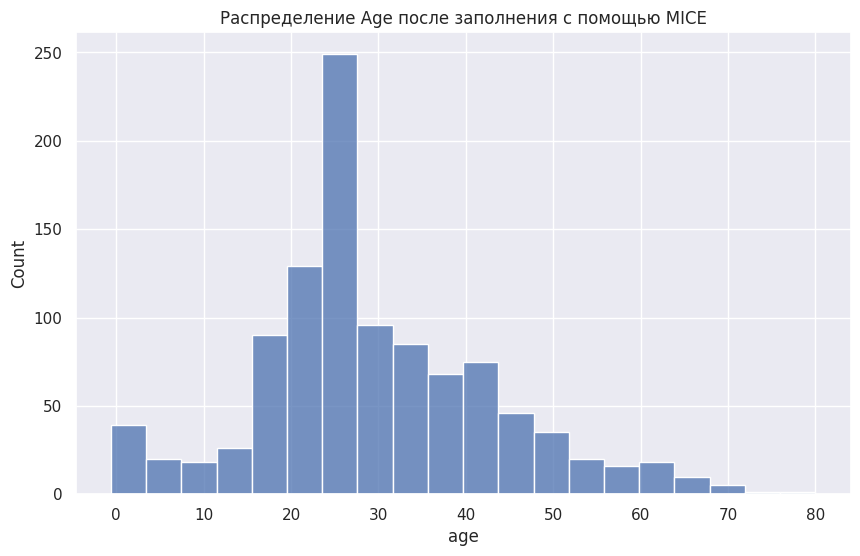

In [122]:
# посмотрим на гистограмму возраста после заполнения пропусков
sns.histplot(mice['age'], bins = 20)
plt.title('Распределение Age после заполнения с помощью MICE');

Так как мы заполняли пропуски линейной регрессией, у нас снова появились отрицательные значения

Количественно оценим получившееся распределение.

In [123]:
# обрежем нулевые и отрицательные значения
mice.age.clip(lower = 0.5, inplace = True)

In [124]:
# оценим среднее арифметическое и медиану
mice.age.mean().round(1), mice.age.median()

(29.5, 27.27107048726126)

In [125]:
# сравним станд.отклонение исходного датасета и данных после алгоритма MICE
titanic.age.std().round(2), mice.age.std().round(2)

(14.59, 13.52)

#### KNN Imputation

##### Sklearn KNNImputer

In [126]:
# сделаем копию датафрейма
knn = titanic.copy()

# создадим объект класса StandardScaler
scaler = StandardScaler()

# масштабируем данные и сразу преобразуем их обратно в датафрейм
knn = pd.DataFrame(scaler.fit_transform(knn), columns = knn.columns)

воспользуемся классом KNNImputer для заполнения пропусков

In [127]:
# импортируем класс KNNImputer
from sklearn.impute import KNNImputer

# создадим объект этого класса с параметрами:
# пять соседей и однаковым весом каждого из них
knn_imputer = KNNImputer(n_neighbors = 5, weights = 'uniform')

# заполним пропуски в столбце Age
knn = pd.DataFrame(knn_imputer.fit_transform(knn), columns = knn.columns)

# проверим отсутствие пропусков и размеры получившегося датафрейма
knn.age.isna().sum(), knn.shape

(0, (1047, 6))

In [128]:
# вернем исходный масштаб
knn = pd.DataFrame(scaler.inverse_transform(knn), columns = knn.columns)

# округлим значение возраста
knn.age = knn.age.round(1)

# посмотрим на результат
knn.head(7)

,pclass,sex,sibsp,parch,fare,age
0,3.0,0.0,0.0,0.0,7.7500,70.5
1,1.0,0.0,0.0,0.0,5.0000,33.0
2,1.0,0.0,0.0,0.0,50.4958,31.0
3,3.0,0.0,0.0,0.0,7.9250,39.0
4,1.0,1.0,0.0,1.0,55.0000,29.8
5,3.0,1.0,0.0,0.0,7.2250,45.0
6,2.0,1.0,2.0,1.0,27.0000,24.0


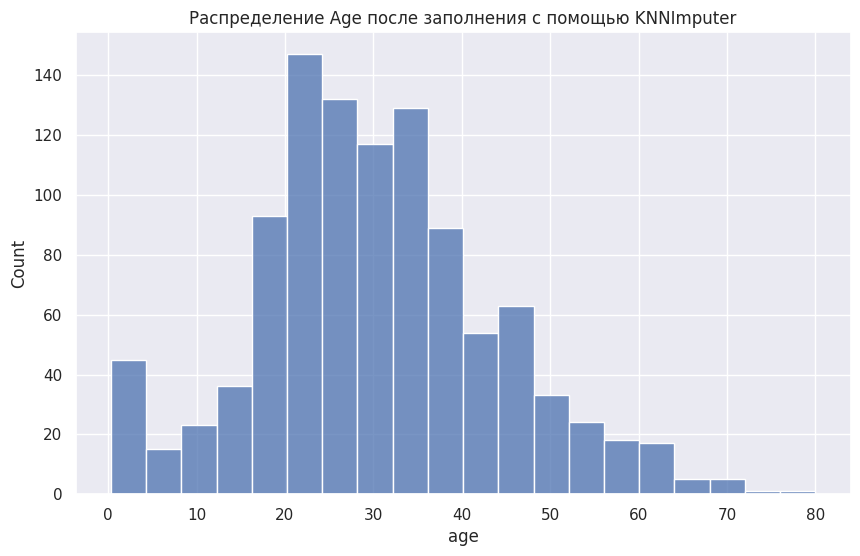

In [129]:
# посмотрим на распределение возраста после заполнения пропусков
sns.histplot(knn['age'], bins = 20)
plt.title('Распределение Age после заполнения с помощью KNNImputer');

Распределение близко к нормальному

##### impyute fast_knn()

Метод ближайших соседей прост и в то же время эффективен.

При этом в базовом варианте его реализации у него есть один недостаток — долгое время работы или, как правильнее сказать, высокая временная сложность (time complexity) алгоритма.

Давайте рассмотрим механику этого метода чуть подробнее. В первую очередь, для лучшего понимания, введем несколько неформальных терминов:

назовем вектором запроса (query vector) то новое наблюдение, для которого мы хотим найти ближайшие к нему вектора (зеленая точка на изображении выше)
вектором сравнения (reference vector) будет то наблюдение, которое уже содержит разметку (класс или числовое значение) или в котором отсутствует пропуск (все остальные точки)
Алгоритм k-ближайших соседей потребует двух циклов.

В первом цикле мы будем поочередно брать по одному вектору запроса
Во втором вложенном в него цикле мы будем для каждого вектора запроса находить расстояние до всех векторов сравнения.
Наконец, найдя и отсортировав вектора сравнения по расстоянию, выберем для каждого вектора запроса k-ближайших.
Далее приступим к решению задачи классификации, регрессии (хотя термин регрессия здесь не вполне корректно применять) или заполнению пропуска.
При большом количестве наблюдений (как векторов запроса, так и векторов сравнения) такая работа может занять очень много времени. Такой вариант реализации алгоритма, его еще называют методом перебора или методом опробования (brute force method), является возможным, но не единственным решением поставленной задачи.

Другим возможным решением является преобразование векторов сравнения в такую структуру данных, по которой поиск соседей будет происходить быстрее (то есть мы оптимизируем второй, вложенный цикл, с первым мы сделать ничего не можем, нам в любом случае нужно перебрать все вектора запроса).

Такой структурой данных может быть, в частности, k-мерное дерево или k-d-дерево (k-diminsional tree, k-d tree).

In [130]:
# сделаем копию датафрейма и масштабируем данные
impyute = titanic.copy()
scaler = StandardScaler()
impyute = scaler.fit_transform(impyute)

# на выходе в переменной impyute содержится массив Numpy
type(impyute)

numpy.ndarray

In [131]:
# установим библиотеку impyute
!pip install impyute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [132]:
# импортируем функцию fast_knn
from impyute.imputation.cs import fast_knn

# передаем этой функции массив Numpy и количество соседей
# (если данные содержатся в формате датафрейма, нужно использовать атрибут .values)
impyute = fast_knn(impyute, k = 5)

# возвращаем исходный масштаб и преобразуем в датафрейм
impyute = pd.DataFrame(scaler.inverse_transform(impyute), columns = titanic.columns)

# округляем столбец возраста
impyute.age = impyute.age.round(1)

# проверим отсутствие пропусков и размеры получившегося датафрейма
impyute.age.isna().sum(), impyute.shape

(0, (1047, 6))

In [133]:
# оценим результат
impyute.head(7)

,pclass,sex,sibsp,parch,fare,age
0,3.0,0.0,0.0,0.0,7.7500,70.5
1,1.0,0.0,0.0,0.0,5.0000,33.0
2,1.0,0.0,0.0,0.0,50.4958,31.0
3,3.0,0.0,0.0,0.0,7.9250,39.0
4,1.0,1.0,0.0,1.0,55.0000,28.5
5,3.0,1.0,0.0,0.0,7.2250,45.0
6,2.0,1.0,2.0,1.0,27.0000,24.0


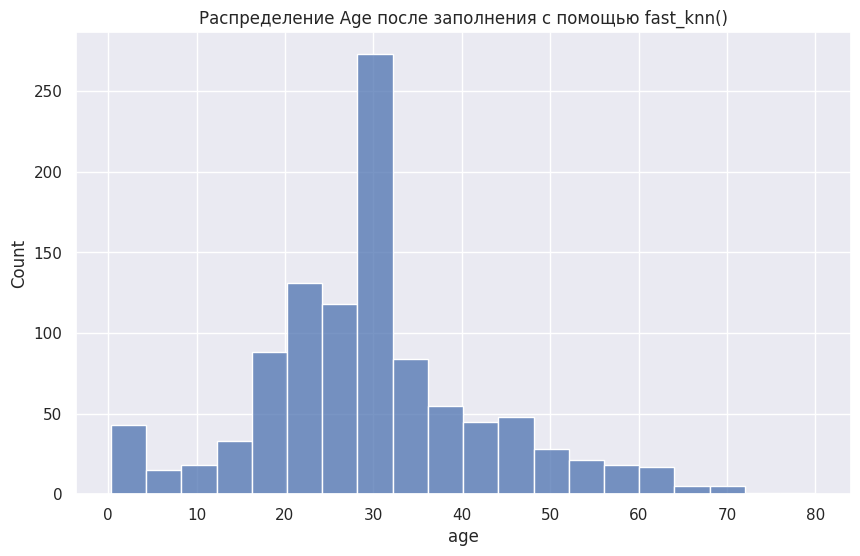

In [134]:
# посмотрим на распределение возраста после заполнения пропусков
sns.histplot(impyute['age'], bins = 20)
plt.title('Распределение Age после заполнения с помощью fast_knn()');

# Для ленивых и продвинутых

`Datacleaner` работает с данными в `pandas DataFrames`.


В настоящее время `Datacleaner` выполняет следующие действия:

- При желании удаляет любую строку с отсутствующим значением

- Заменяет отсутствующие значения модой (для категориальных переменных) или медианой (для непрерывных переменных) по столбцам

- Кодирует нечисловые переменные (например, категориальные) числовыми эквивалентами

In [157]:
pip install datacleaner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for datacleaner: filename=datacleaner-0.1.5-py3-none-any.whl size=7408 sha256=87e632776d0c462408d0470beebcd8bf721472449043673b1e14123a43d1be2a
  Stored in directory: /root/.cache/pip/wheels/8f/bc/5b/f7ca5772f61851334a8580f3ede175b92a7122eef3464e2b3d
Successfully built datacleaner


In [159]:
# создадим датафрейм из словаря
df = pd.DataFrame({'month' :   [np.nan, '01/02/2022', '01/03/2022', '01/03/2022', '01/04/2022', '01/05/2022', '01/06/2022', '01/07/2022', '01/08/2022', '01/09/2022', '01/10/2022', '01/11/2022', '01/12/2022', '01/12/2022'],
                           'profit' :  ['1.20$', '1.30$', '1.25$', '1.25$', '1.27$', '1.13$', '1.23$', '1.20$', '1.31$', '1.24$', '1.18$', '1.17$', '1.23$', '1.23$'],
                           'MoM' :     [np.nan, -0.02, 0.01, 0.02, -0.01, -0.015, 0.017, 0.035, 0.02, 0.01, 0.00, -0.01, 2.00, 2.00],
                           'high' :    ['Dubai', 'Paris', 'singapour', 'singapour', 'moscow', 'Paris', 'Madrid', 'moscow', 'london', 'london', 'Moscow', 'Rome', 'madrid', 'madrid']
                           })

df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,month,profit,MoM,high
0,NaN,1.20$,NaN,Dubai
1,01/02/2022,1.30$,-0.020,Paris
2,01/03/2022,1.25$,0.010,singapour
3,01/03/2022,1.25$,0.020,singapour
4,01/04/2022,1.27$,-0.010,moscow
5,01/05/2022,1.13$,-0.015,Paris
6,01/06/2022,1.23$,0.017,Madrid
7,01/07/2022,1.20$,0.035,moscow
8,01/08/2022,1.31$,0.020,london
9,01/09/2022,1.24$,0.010,london


In [160]:
from datacleaner import autoclean



autoclean(df)

,month,profit,MoM,high
0,1,3,0.010,0
1,0,8,-0.020,3
2,1,6,0.010,8
3,1,6,0.020,8
4,2,7,-0.010,7
5,3,0,-0.015,3
6,4,4,0.017,1
7,5,3,0.035,7
8,6,9,0.020,5
9,7,5,0.010,5


`Dabl` создан, чтобы упростить работу с моделями ML для новичков. Чтобы установить её, выполните `pip install dabl`, импортируйте пакет командой `import dabl` — и можно начинать. Выполните также строчку `dabl.clean(data)`, чтобы получить информацию о признаках, например о том, есть ли какие-то бесполезные признаки. Она также показывает непрерывные, категориальные признаки и признаки с высокой кардинальностью.

In [140]:
!pip install dabl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 12.1 MB/s eta 0:00:00


In [141]:
import dabl

In [147]:
dabl.clean(titanic, verbose=5).head(2)

Detected feature types:
continuous                  2
dirty_float                 0
low_card_int_ordinal        2
low_card_int_categorical    0
categorical                 2
date                        0
free_string                 0
useless                     0
dtype: int64


,pclass,sex,sibsp,parch,fare,age
727,3.0,0,0.0,0.0,7.75,70.5
51,1.0,0,0.0,0.0,5.00,33.0


Чтобы визуализировать конкретный признак, можно выполнить `dabl.plot(data)`.

/usr/local/lib/python3.10/dist-packages/dabl/plot/supervised.py:622: FutureWarning: The second positional argument of plot is a Series 'y'. If passing a column name, use a keyword.
  warnings.warn("The second positional argument of plot is a Series 'y'."


Target looks like classification
Linear Discriminant Analysis training set score: 0.521


[<Axes: title={'center': 'Target distribution'}, xlabel='count', ylabel='pclass'>,
 [array([[<Axes: ylabel='sibsp'>, <Axes: >, <Axes: >, <Axes: >],
         [<Axes: ylabel='parch'>, <Axes: >, <Axes: >, <Axes: >],
         [<Axes: ylabel='fare'>, <Axes: >, <Axes: >, <Axes: >],
         [<Axes: xlabel='sibsp', ylabel='age'>, <Axes: xlabel='parch'>,
          <Axes: xlabel='fare'>, <Axes: xlabel='age'>]], dtype=object),
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 400x400 with 1 Axes>],
 array([[<Axes: title={'center': 'sex'}>]], dtype=object)]

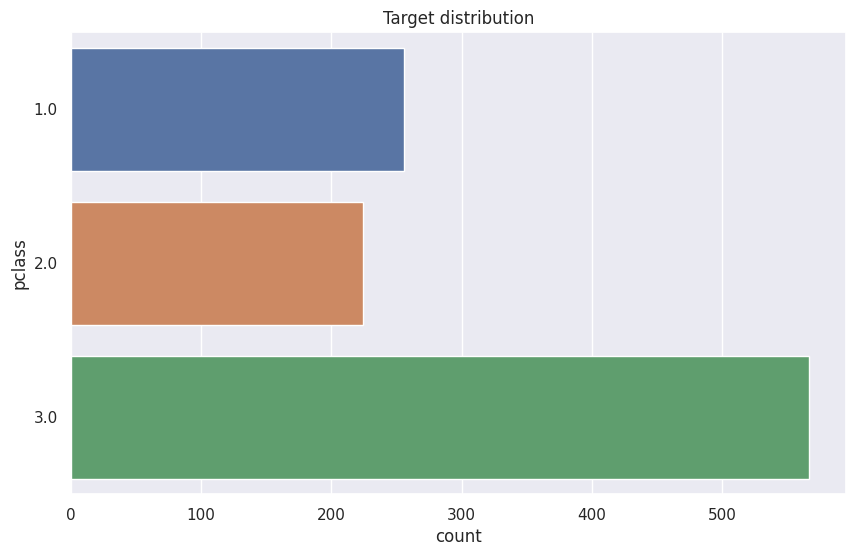

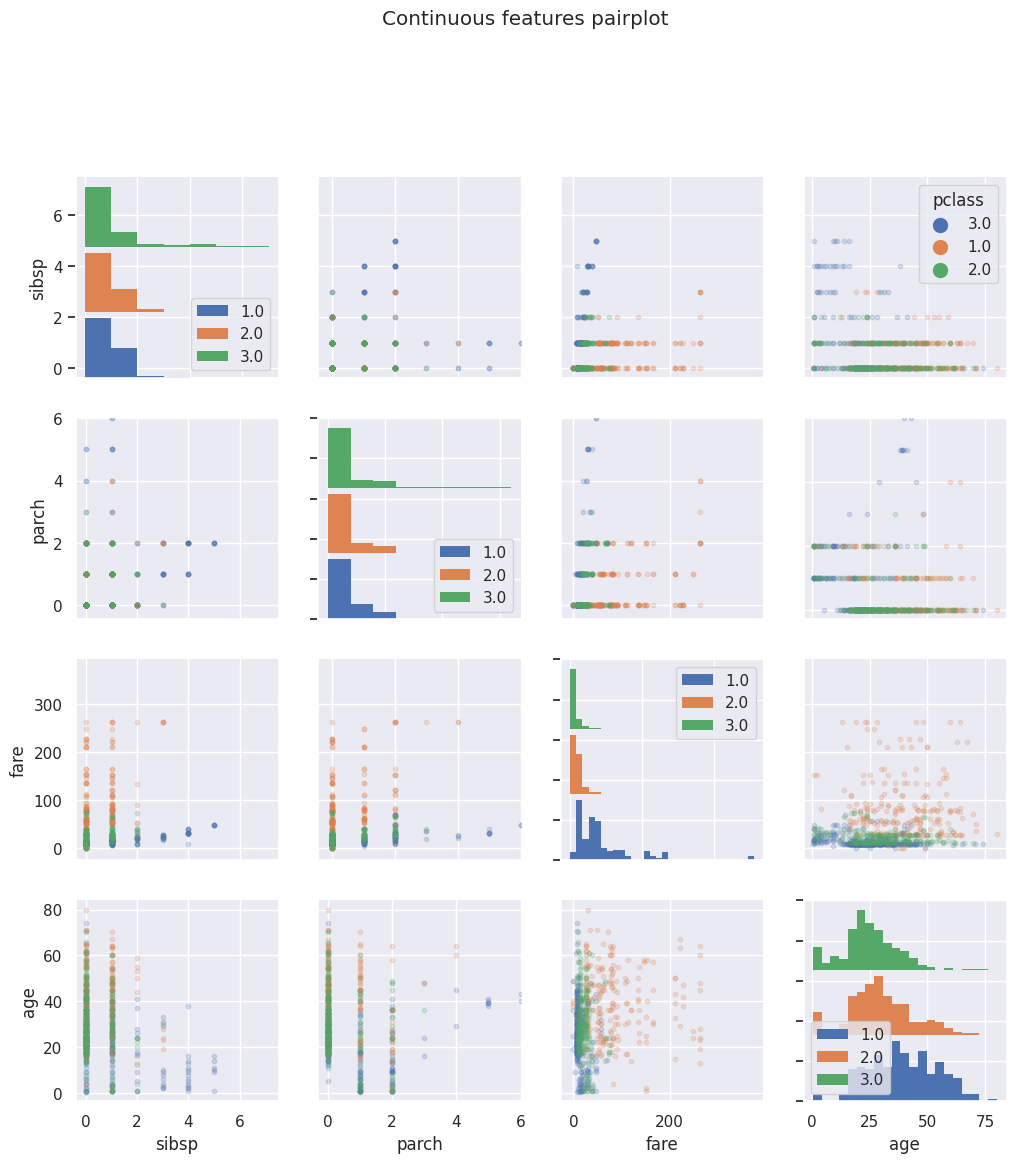

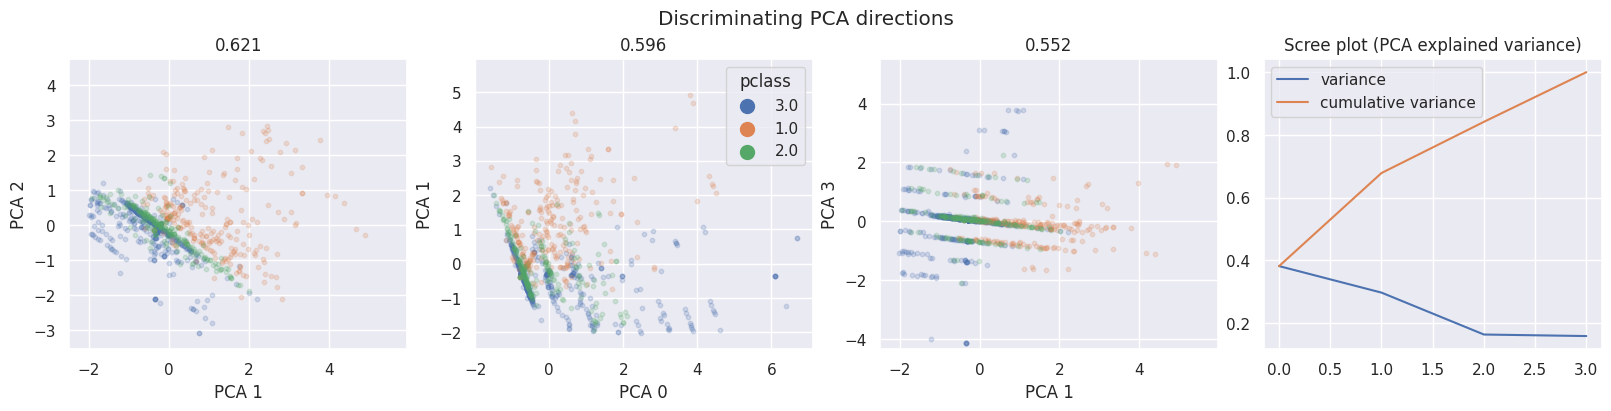

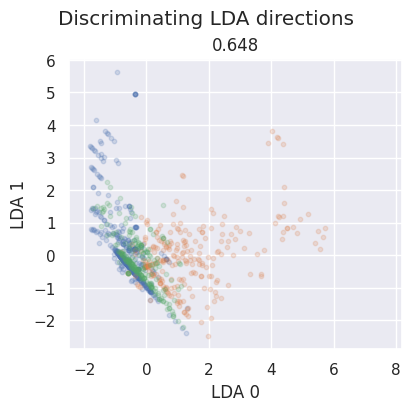

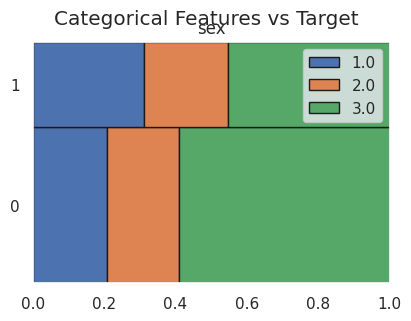

In [149]:
dabl.plot(titanic, 'pclass')

Можно создать несколько моделей вот так: `dabl.AnyClassifier`, или так: `dabl.Simplefier()`, как это делается в `scikit-learn`. Но на этом шаге придётся предпринять некоторые обычные шаги, такие как создание тренировочного и тестового набора данных, вызов, обучение модели и вывод её прогноза.

In [151]:
# импортируем датасет Титаник
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X.drop(['boat', 'body', 'home.dest'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


<IPython.core.display.Javascript object>

`Dabl` итеративно проходит через множество моделей, включая `Dummy Classifier` (фиктивный классификатор), `GaussianNB` (гауссовский наивный Байес), деревья решений различной глубины и логистическую регрессию. В конце библиотека показывает лучшую модель.

In [152]:
sc = dabl.SimpleClassifier().fit(X_train, y_train)
print("Accuracy score", sc.score(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

Running DummyClassifier()
accuracy: 0.618 average_precision: 0.382 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.382
=== new best DummyClassifier() (using recall_macro):
accuracy: 0.618 average_precision: 0.382 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.382

Running GaussianNB()
accuracy: 0.649 average_precision: 0.715 roc_auc: 0.801 recall_macro: 0.547 f1_macro: 0.487
=== new best GaussianNB() (using recall_macro):
accuracy: 0.649 average_precision: 0.715 roc_auc: 0.801 recall_macro: 0.547 f1_macro: 0.487

Running MultinomialNB()
accuracy: 0.720 average_precision: 0.714 roc_auc: 0.773 recall_macro: 0.666 f1_macro: 0.669
=== new best MultinomialNB() (using recall_macro):
accuracy: 0.720 average_precision: 0.714 roc_auc: 0.773 recall_macro: 0.666 f1_macro: 0.669

Running DecisionTreeClassifier(class_weight='balanced', max_depth=1)
accuracy: 0.785 average_precision: 0.625 roc_auc: 0.765 recall_macro: 0.765 f1_macro: 0.768
=== new best DecisionTreeClassifier(class_weight='balanced', 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**SweetViz**

Это  библиотека, которая генерирует прекрасные визуализации, чтобы вывести ваш исследовательский анализ данных на новый уровень при помощи всего двух строк кода. Вывод библиотеки — интерактивный файл HTML. Давайте посмотрим на неё в общем и целом. Установить её можно так: `pip install sweetviz`, а импортировать в блокнот — строкой `import sweetviz as sv`

Библиотека создаёт HTML-файл с исследовательским анализом данных на весь набор данных и разбивает его таким образом, что каждый признак вы можете проанализировать отдельно. Возможно также получить численные или категориальные ассоциации с другими признаками; малые, большие и часто встречающиеся значения. Также визуализация изменяется в зависимости от типа данных.

In [154]:
pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 60.6 MB/s eta 0:00:00


In [156]:
import sweetviz as sv

my_report = sv.analyze(titanic)
my_report.show_html()

/usr/local/lib/python3.10/dist-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/usr/local/lib/python3.10/dist-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecate

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


`PyForest` — это одна из  удобных библиотек. С её помощью в  `Jupyter` можно импортировать более 40  библиотек (`Pandas, Matplotlib, Seaborn, Tensorflow, Sklearn, NLTK, XGBoost, Plotly, Keras, Numpy` и другие) при помощи всего одной строки кода.

Выполните `pip install pyforest`. Для импорта библиотек в ваш блокнот введите команду `from pyforest import *`, и можно начинать. Чтобы узнать, какие библиотеки импортированы, выполните `lazy_imports()`.

In [139]:
!pip install pyforest

from pyforest import *

lazy_imports()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14606 sha256=cda293b88d50f192eb7ab5c52dceeb652dbc010e4d3c0c1a9b3e921b32675f07
  Stored in directory: /root/.cache/pip/wheels/9e/7d/2c/5d2f5e62de376c386fd3bf5a8e5bd119ace6a9f48f49df6017
Successfully built pyforest


['from sklearn.feature_extraction.text import TfidfVectorizer',
 'import cv2',
 'import seaborn as sns',
 'from sklearn.preprocessing import OneHotEncoder',
 'import keras',
 'import pickle',
 'import os',
 'import bokeh',
 'import re',
 'from sklearn.linear_model import ElasticNetCV',
 'import sys',
 'import skimage',
 'from sklearn.impute import SimpleImputer',
 'from sklearn import svm',
 'import datetime as dt',
 'import fbprophet',
 'from sklearn.manifold import TSNE',
 'import numpy as np',
 'from sklearn.model_selection import train_test_split',
 'import statistics',
 'from sklearn.decomposition import PCA',
 'from sklearn.ensemble import RandomForestRegressor',
 'import spacy',
 'import matplotlib as mpl',
 'import awswrangler as wr',
 'from sklearn.model_selection import RandomizedSearchCV',
 'import gensim',
 'from sklearn.linear_model import ElasticNet',
 'import imutils',
 'import plotly.express as px',
 'from sklearn.ensemble import RandomForestClassifier',
 'from scipy im